# Credit risk analysis of loan customers

# Executive summary

# Journey

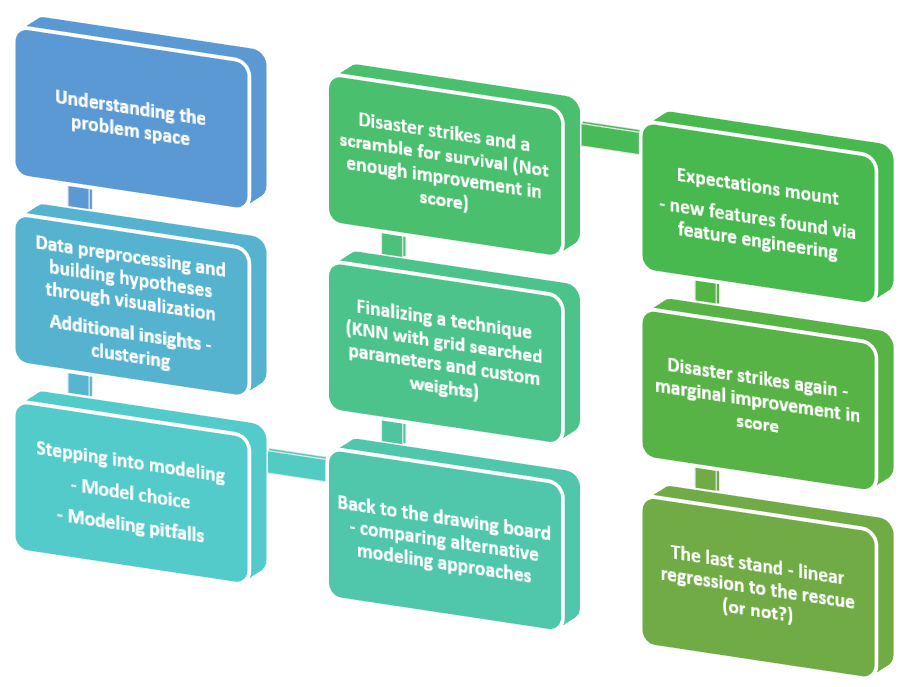

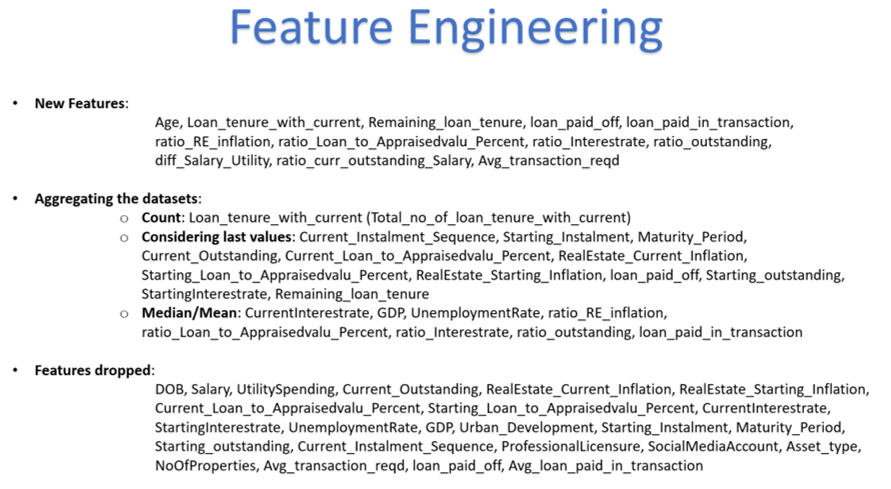

# New Features Summary

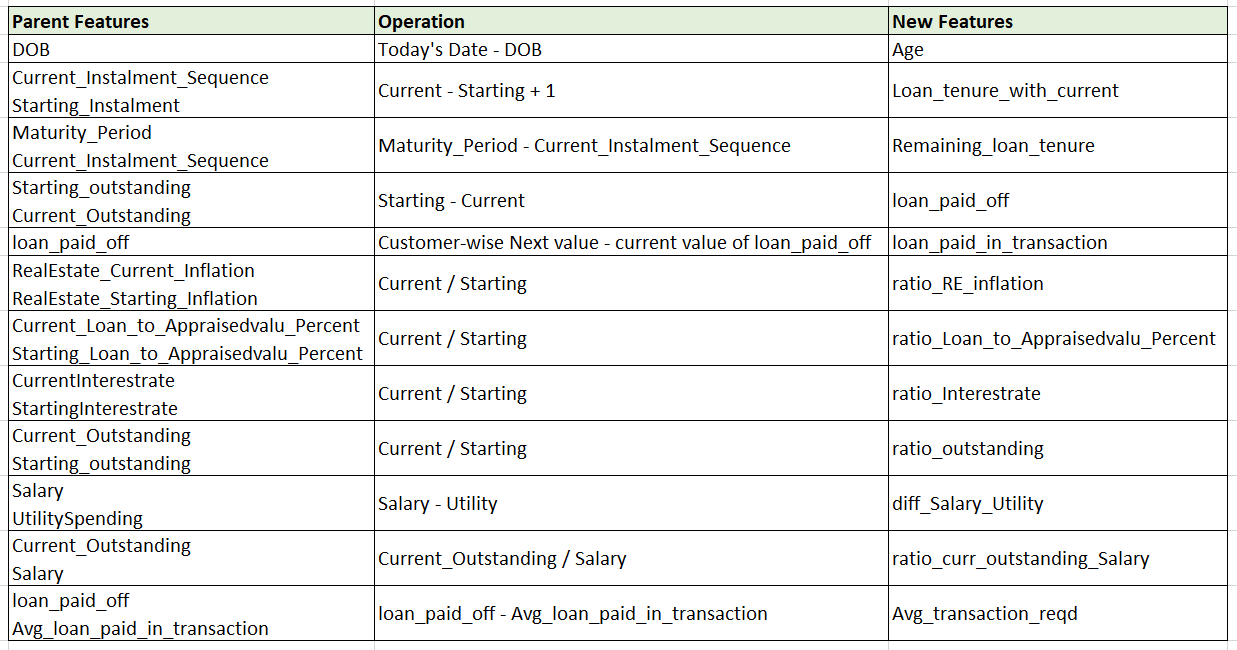

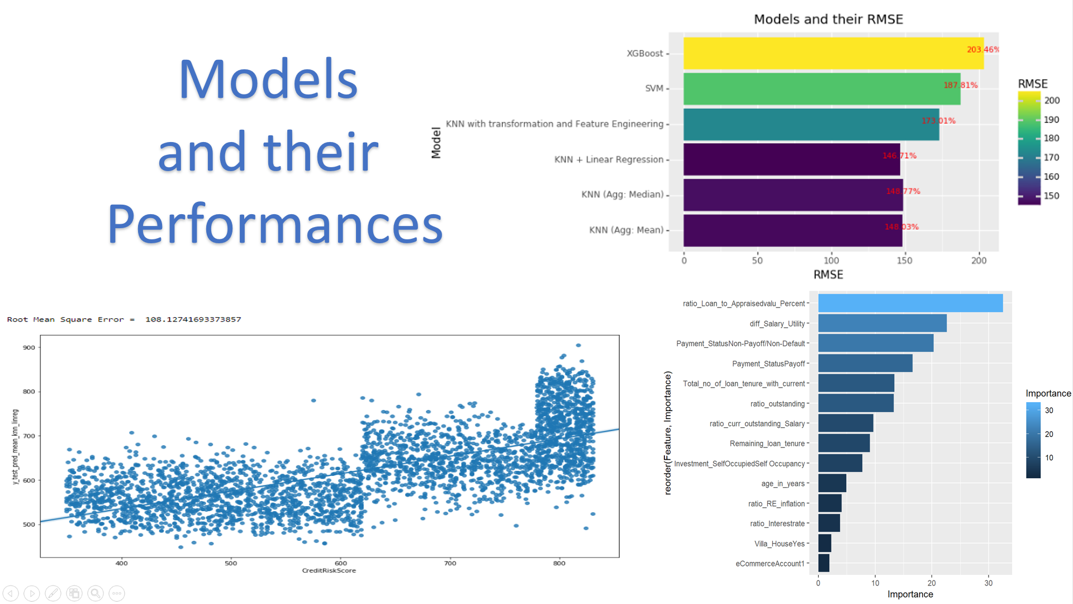

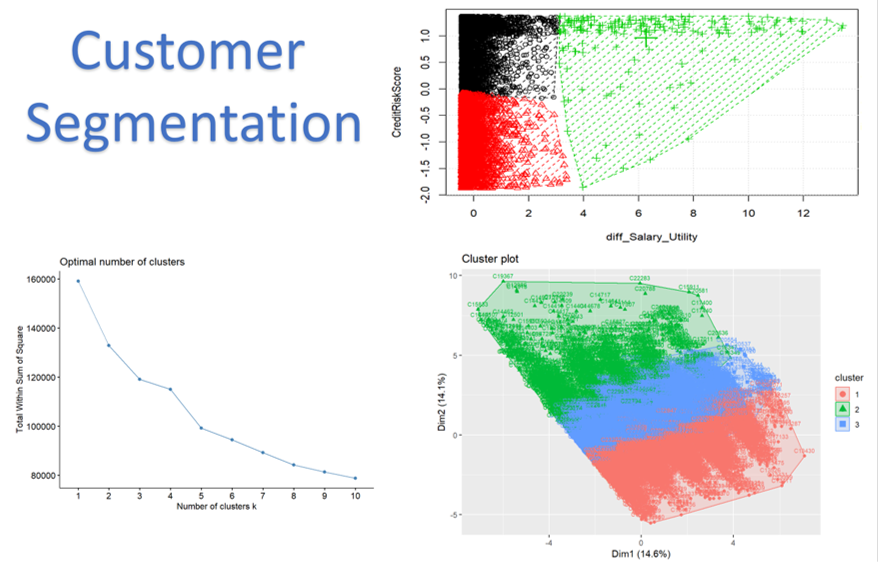

In [1]:
import pandas as pd
import numpy as np
from copy import deepcopy
import os
import math
from datetime import datetime as DateTime

### ============================== START OF CODE ================================

## Data Loading

### The data is given as two separate files, one for train and another for test.

#### Reading both the train datasets

**1. Train-1557019772293 : Dataset of Customer demographics including the target attribute(CreditRiskScore)**

**2. Train_PaymentHistory-1557019802161 : Dataset of payment history**

In [2]:
trainDF_PayHist = pd.read_excel("../Data/Train_PaymentHistory-1557019802161.xlsx")
trainDF_CreditRisk = pd.read_excel("../Data/Train-1557019772293.xlsx")

#### View Shape of the data

In [3]:
# print("Shape of trainDF_PayHist is " + str(trainDF_PayHist.shape))
# print("Shape of trainDF_CreditRisk is " + str(trainDF_CreditRisk.shape))

#### Dealing with outliers

In [4]:
# Removing Outliers
print(trainDF_CreditRisk.shape)

REMOVE_OUTLIERS = True
OUTLIER_METHOD = 'USER_DEFINED'  ## Options: "USER_DEFINED" or 'IQR'
USER_DEFINED_OUTLIER_THRESHOLD = 100000

if REMOVE_OUTLIERS:
    if OUTLIER_METHOD == 'IQR':
        q1 = trainDF_CreditRisk.Salary.quantile(0.25)
        q3 = trainDF_CreditRisk.Salary.quantile(0.75)
        iqr = q3-q1

        lowerbound = q1-1.5*iqr
        upperbound = q3+1.5*iqr

        ## first cut -replace Salary outliers with NaN and drop those records
        func = lambda x: np.where(x>upperbound, np.nan, x)
        trainDF_CreditRisk['Salary'] = trainDF_CreditRisk['Salary'].transform(func)
        trainDF_CreditRisk.dropna(inplace=True)
    
    elif OUTLIER_METHOD == 'USER_DEFINED':
        func = lambda x: np.where(x > USER_DEFINED_OUTLIER_THRESHOLD, np.nan, x)
        trainDF_CreditRisk['Salary'] = trainDF_CreditRisk['Salary'].transform(func)
        trainDF_CreditRisk.dropna(inplace=True)
    
print(trainDF_CreditRisk.shape)

(11093, 9)
(11071, 9)


## Feature Engineering 1
### Adding new features

#### First on the payment history data set

In [5]:
CUSTOM_FEATURES = True

if CUSTOM_FEATURES:
    ## Calculate age using DOB
    trainDF_CreditRisk['DOB'] = pd.to_datetime(trainDF_CreditRisk['DOB'], format="%Y-%m-%d")
    
    # create a column with today's date time
    trainDF_CreditRisk['today'] = DateTime.today()
    # Create timeDiff as difference between today and your Datetime column
    trainDF_CreditRisk['timeDiff'] = trainDF_CreditRisk.today - trainDF_CreditRisk['DOB']
    
    # Create age columns (remember to use only one at a time. start with age_in_years

    trainDF_CreditRisk['age_in_days'] = trainDF_CreditRisk.timeDiff.dt.days
    trainDF_CreditRisk['age_in_years'] = (trainDF_CreditRisk.timeDiff.dt.days/365).apply(lambda x: int(x))
    trainDF_CreditRisk['age_in_months'] = (trainDF_CreditRisk.timeDiff.dt.days/365*12).apply(lambda x: int(x))
        

    ## Calculate additional features
    trainDF_PayHist['Loan_tenure_with_current'] = trainDF_PayHist['Current_Instalment_Sequence'] - \
                                                    trainDF_PayHist['Starting_Instalment'] + 1
    
    trainDF_PayHist['Remaining_loan_tenure'] = trainDF_PayHist['Maturity_Period'] - \
                                                    trainDF_PayHist['Current_Instalment_Sequence']
    
    trainDF_PayHist['loan_paid_off'] = trainDF_PayHist['Starting_outstanding'] - \
                                        trainDF_PayHist['Current_Outstanding']
    
    ## Group by the Customer ID
    trainDF_PayHist_groupByCustID = trainDF_PayHist.groupby('CustomerID')
    
    ## Sort the payment history dataframe by customerID and loan_tenure_with_current, then groupby customerID, then 
    ## diff() the loan_paid_off column. This will give a new column
    trainDF_PayHist['loan_paid_in_transaction'] = trainDF_PayHist.sort_values(['CustomerID','Loan_tenure_with_current'])\
                                        .groupby('CustomerID')['loan_paid_off'].diff()
    
    trainDF_PayHist['ratio_RE_inflation'] = trainDF_PayHist['RealEstate_Current_Inflation']/trainDF_PayHist['RealEstate_Starting_Inflation']
    
    trainDF_PayHist['ratio_Loan_to_Appraisedvalu_Percent'] = trainDF_PayHist['Current_Loan_to_Appraisedvalu_Percent']/trainDF_PayHist['Starting_Loan_to_Appraisedvalu_Percent']
    
    trainDF_PayHist['ratio_Interestrate'] = trainDF_PayHist['CurrentInterestrate']/trainDF_PayHist['StartingInterestrate']
    
    trainDF_PayHist['ratio_outstanding'] = trainDF_PayHist['Current_Outstanding']/trainDF_PayHist['Starting_outstanding']
    
    

In [6]:
trainDF_PayHist.head()

,CustomerID,Current_Instalment_Sequence,Starting_Instalment,Maturity_Period,Current_Outstanding,Current_Loan_to_Appraisedvalu_Percent,CurrentInterestrate,RealEstate_Current_Inflation,GDP,UnemploymentRate,...,RealEstate_Starting_Inflation,Payment_Status,Loan_tenure_with_current,Remaining_loan_tenure,loan_paid_off,loan_paid_in_transaction,ratio_RE_inflation,ratio_Loan_to_Appraisedvalu_Percent,ratio_Interestrate,ratio_outstanding
0,C12116,25,25,113,41303.42,24.498336,9.2,2.2629,2.899137,4.7,...,0.8703,Non-Payoff/Non-Default,1,88,3696.58,NaN,2.600138,0.353002,1.0,0.917854
1,C12116,26,25,113,41061.95,24.483867,9.2,2.2510,2.151365,4.7,...,0.8703,Non-Payoff/Non-Default,2,87,3938.05,241.47,2.586464,0.352793,1.0,0.912488
2,C12116,27,25,113,40804.42,24.626795,9.2,2.2239,2.361722,4.4,...,0.8703,Non-Payoff/Non-Default,3,86,4195.58,257.53,2.555326,0.354853,1.0,0.906765
3,C12116,28,25,113,40483.89,24.735883,9.2,2.1967,1.229172,4.6,...,0.8703,Non-Payoff/Non-Default,4,85,4516.11,320.53,2.524072,0.356425,1.0,0.899642
4,C12116,29,25,113,40367.06,24.925476,9.2,2.1737,1.692969,4.5,...,0.8703,Non-Payoff/Non-Default,5,84,4632.94,116.83,2.497644,0.359157,1.0,0.897046


## Feature Engineering 2
### Aggregating features from trainDF_PayHist to merge them with trainDF_CreditRisk in a seperate dataframe named finalDF

#### Aggregating by Count: 
For every customer, selecting total number of trasactions with the currect company

In [7]:
# Aggregating 'Loan_tenure_with_current' by count, renaming it to 'Total_no_of_loan_tenure_with_current' and merging it with finalDF

trainDF_PayHist_transactionPerCust = trainDF_PayHist.groupby('CustomerID').agg({'Loan_tenure_with_current':'count'})
## need to reset the index because the agg() operation sets the index of the resulting data frame as the column on
## which the grouping has been done
trainDF_PayHist_transactionPerCust.reset_index(inplace=True)
trainDF_PayHist_transactionPerCust.rename(index=str, columns={"Loan_tenure_with_current": "Total_no_of_loan_tenure_with_current"}, inplace=True)
# trainDF_PayHist_transactionPerCust.head()

# Now, join the above two data frames with the Credit Risk table with the Customer ID as the join-on column

finalDF = deepcopy(trainDF_CreditRisk)


finalDF = finalDF.merge(trainDF_PayHist_transactionPerCust,how='left',left_on = 'CustomerID',\
                      right_on='CustomerID',left_index=False, right_index=False)
# finalDF.head()

#### Aggregating by taking last values:
Selecting only the last value for all categorical variables

In [8]:
trainDF_PayHist_CategCols = trainDF_PayHist.select_dtypes('object')
# trainDF_PayHist_CategCols.head()

trainDF_PayHist_CategCols_lastVals = trainDF_PayHist_CategCols.groupby('CustomerID').agg('last').reset_index()
# trainDF_PayHist_CategCols_lastVals.head()

# Now, join the data frame with last values of categorical columns to the finalDF table containing the
# credit risk data with the Customer ID as the join-on column

finalDF = finalDF.merge(trainDF_PayHist_CategCols_lastVals,how='left',left_on = 'CustomerID',\
                      right_on='CustomerID',left_index=False, right_index=False)
finalDF.head()


# Selecting appropriate numerical columns from trainDF_PayHist which can be directly flattened using the latest value for 
# each customer (i.e. the value for the last instalment)

trainDF_PayHist_NumericalCols_direct_flaten = trainDF_PayHist[['CustomerID','Current_Instalment_Sequence', 'Starting_Instalment', 
                                                               'Maturity_Period', 'Current_Outstanding', 
                                                               'Current_Loan_to_Appraisedvalu_Percent', 
                                                               'RealEstate_Current_Inflation', 'Starting_outstanding',
                                                               'Starting_Loan_to_Appraisedvalu_Percent', 'StartingInterestrate',
                                                               'RealEstate_Starting_Inflation', 'Remaining_loan_tenure',
                                                               'loan_paid_off']]
# trainDF_PayHist_NumericalCols_direct_flaten.head()

trainDF_PayHist_NumericalCols_direct_flaten_lastVals = trainDF_PayHist_NumericalCols_direct_flaten.\
                                                        groupby('CustomerID').\
                                                        agg('last').reset_index()

# trainDF_PayHist_NumericalCols_direct_flaten_lastVals.head()

# Now, join the data frame with last values of categorical columns to the finalDF table containing the
# credit risk data with the Customer ID as the join-on column

finalDF = finalDF.merge(trainDF_PayHist_NumericalCols_direct_flaten_lastVals,how='left',left_on = 'CustomerID',\
                      right_on='CustomerID',left_index=False, right_index=False)
finalDF.head()

,CustomerID,DOB,Salary,ProfessionalLicensure,UtilitySpending,eCommerceAccount,SocialMediaAccount,NoOfProperties,CreditRiskScore,today,...,Maturity_Period,Current_Outstanding,Current_Loan_to_Appraisedvalu_Percent,RealEstate_Current_Inflation,Starting_outstanding,Starting_Loan_to_Appraisedvalu_Percent,StartingInterestrate,RealEstate_Starting_Inflation,Remaining_loan_tenure,loan_paid_off
0,C12116,1969-04-22,1238.006112,0,492.726433,1,No,2,711,2019-05-17 13:36:46.913549,...,113,29087.21,26.658065,1.4645,45000.0,69.4,9.20,0.8703,65,15912.79
1,C12117,1981-04-24,1633.000000,1,477.870359,1,Yes,1,767,2019-05-17 13:36:46.913549,...,138,160044.34,73.431289,1.7335,164500.0,70.0,7.50,1.8691,104,4455.66
2,C12118,1970-02-10,1489.000000,0,351.593736,1,Yes,1,827,2019-05-17 13:36:46.913549,...,105,34562.30,16.897997,1.8982,44000.0,52.5,13.00,0.7778,45,9437.70
3,C12119,1976-04-22,1241.000000,0,403.589993,1,No,1,795,2019-05-17 13:36:46.913549,...,106,27355.73,18.466696,1.8982,34800.0,56.9,12.35,0.7837,46,7444.27
4,C12120,1975-04-24,1074.000000,1,406.066005,1,No,1,827,2019-05-17 13:36:46.913549,...,107,43102.83,18.516390,1.8982,61600.0,64.3,9.25,0.7812,47,18497.17


#### Aggregating by taking mean/median:
Selecting only the median values of all the given below features

In [9]:
## ENVIRONMENT VARIABLES FOR AGGREGATION

## Setting for choosing the aggregation metric to be either MEAN or MEDIAN

AGG_NUMERIC_METRIC = 'median' ## choose either 'median' or 'mean'

thelist_avg_values = ['CustomerID', 'CurrentInterestrate', 'GDP', 'UnemploymentRate', 'ratio_RE_inflation',
                      'ratio_Loan_to_Appraisedvalu_Percent','ratio_Interestrate', 'ratio_outstanding', 'loan_paid_in_transaction']


trainDF_PayHist_NumericalCols_avg = trainDF_PayHist[thelist_avg_values]

trainDF_PayHist_NumericalCols_flaten_avg = trainDF_PayHist_NumericalCols_avg.\
                                                        groupby('CustomerID').\
                                                        agg(AGG_NUMERIC_METRIC).reset_index()

trainDF_PayHist_NumericalCols_flaten_avg.head()


finalDF = finalDF.merge(trainDF_PayHist_NumericalCols_flaten_avg,how='left',left_on = 'CustomerID',\
                      right_on='CustomerID',left_index=False, right_index=False)

finalDF.rename(index=str, columns={"loan_paid_in_transaction": "Avg_loan_paid_in_transaction"}, inplace=True)

finalDF.head()

,CustomerID,DOB,Salary,ProfessionalLicensure,UtilitySpending,eCommerceAccount,SocialMediaAccount,NoOfProperties,CreditRiskScore,today,...,Remaining_loan_tenure,loan_paid_off,CurrentInterestrate,GDP,UnemploymentRate,ratio_RE_inflation,ratio_Loan_to_Appraisedvalu_Percent,ratio_Interestrate,ratio_outstanding,Avg_loan_paid_in_transaction
0,C12116,1969-04-22,1238.006112,0,492.726433,1,No,2,711,2019-05-17 13:36:46.913549,...,65,15912.79,9.200,1.653669,8.05,1.850282,0.379089,1.000000,0.723073,363.550
1,C12117,1981-04-24,1633.000000,1,477.870359,1,Yes,1,767,2019-05-17 13:36:46.913549,...,104,4455.66,10.500,1.771829,4.70,1.150554,0.850445,1.400000,0.978374,280.920
2,C12118,1970-02-10,1489.000000,0,351.593736,1,Yes,1,827,2019-05-17 13:36:46.913549,...,45,9437.70,12.125,1.717053,7.30,2.226408,0.407987,0.932692,0.898917,205.730
3,C12119,1976-04-22,1241.000000,0,403.589993,1,No,1,795,2019-05-17 13:36:46.913549,...,46,7444.27,12.350,1.717053,7.30,2.209647,0.407744,1.000000,0.887887,147.350
4,C12120,1975-04-24,1074.000000,1,406.066005,1,No,1,827,2019-05-17 13:36:46.913549,...,47,18497.17,9.250,1.717053,7.30,2.216718,0.382561,1.000000,0.833038,353.165


## Feature Engineering 3
### Adding new features to finalDF
### Dropping features which are not required

In [10]:
if CUSTOM_FEATURES:
    finalDF['diff_Salary_Utility'] = finalDF['Salary'] - finalDF['UtilitySpending']
        
    finalDF['ratio_curr_outstanding_Salary'] = finalDF['Current_Outstanding']/finalDF['Salary']
    
    finalDF['Avg_transaction_reqd'] = finalDF['loan_paid_off']/finalDF['Avg_loan_paid_in_transaction']
    
    finalDF.drop(['DOB', 'today','timeDiff','age_in_days', 'age_in_months'], axis=1,inplace=True)
    
    finalDF.drop(['Salary','UtilitySpending', 'Current_Outstanding', 'loan_paid_off', 'Avg_loan_paid_in_transaction'], axis=1, inplace=True)
    
    finalDF.drop(['RealEstate_Current_Inflation', 'RealEstate_Starting_Inflation'], axis=1, inplace=True)
    
    finalDF.drop(['Current_Loan_to_Appraisedvalu_Percent','Starting_Loan_to_Appraisedvalu_Percent'], axis=1, inplace=True)
    
    finalDF.drop(['CurrentInterestrate','StartingInterestrate'], axis=1, inplace=True)
    
    finalDF = finalDF.replace([np.inf,-np.inf],np.nan)
    
    finalDF.drop(['UnemploymentRate','GDP', 'Urban_Development'], axis=1, inplace=True)
    


In [11]:
finalDF.isnull().sum()

# finalDF = finalDF.dropna()

CustomerID                                 0
ProfessionalLicensure                      0
eCommerceAccount                           0
SocialMediaAccount                         0
NoOfProperties                             0
CreditRiskScore                            0
age_in_years                               0
Total_no_of_loan_tenure_with_current       0
Asset_type                                 0
Villa_House                                0
Investment_SelfOccupied                    0
Payment_Status                             0
Current_Instalment_Sequence                0
Starting_Instalment                        0
Maturity_Period                            0
Starting_outstanding                       0
Remaining_loan_tenure                      0
ratio_RE_inflation                         0
ratio_Loan_to_Appraisedvalu_Percent        0
ratio_Interestrate                      1495
ratio_outstanding                          0
diff_Salary_Utility                        0
ratio_curr

In [12]:
REPLACE_NULL=True

if REPLACE_NULL:
    df = finalDF.select_dtypes(include=np.number)
    df = df.apply(lambda x: x.fillna(value=np.mean(x)))
    
    for col in list(df.columns.values):
        finalDF[col] = df[col]
#     finalDF['ratio_Interestrate'] = finalDF['ratio_Interestrate'].fillna(value=np.mean(finalDF['ratio_Interestrate']))
else:
    finalDF.drop("ratio_Interestrate", axis=1, inplace=True)
    finalDF = finalDF.dropna()

In [13]:
finalDF.isnull().sum()

CustomerID                              0
ProfessionalLicensure                   0
eCommerceAccount                        0
SocialMediaAccount                      0
NoOfProperties                          0
CreditRiskScore                         0
age_in_years                            0
Total_no_of_loan_tenure_with_current    0
Asset_type                              0
Villa_House                             0
Investment_SelfOccupied                 0
Payment_Status                          0
Current_Instalment_Sequence             0
Starting_Instalment                     0
Maturity_Period                         0
Starting_outstanding                    0
Remaining_loan_tenure                   0
ratio_RE_inflation                      0
ratio_Loan_to_Appraisedvalu_Percent     0
ratio_Interestrate                      0
ratio_outstanding                       0
diff_Salary_Utility                     0
ratio_curr_outstanding_Salary           0
Avg_transaction_reqd              

In [14]:
trainDF = deepcopy(finalDF)

In [15]:
trainDF.drop(['Starting_Instalment', 'Maturity_Period', 'Starting_outstanding',\
              'Current_Instalment_Sequence'], axis=1, inplace=True)

In [16]:
# let's break down the columns by their type (i.e. int64, float64, object)
trainDF.columns.to_series().groupby(trainDF.dtypes).groups

{dtype('int64'): Index(['ProfessionalLicensure', 'eCommerceAccount', 'NoOfProperties',
        'CreditRiskScore', 'age_in_years',
        'Total_no_of_loan_tenure_with_current', 'Remaining_loan_tenure'],
       dtype='object'),
 dtype('float64'): Index(['ratio_RE_inflation', 'ratio_Loan_to_Appraisedvalu_Percent',
        'ratio_Interestrate', 'ratio_outstanding', 'diff_Salary_Utility',
        'ratio_curr_outstanding_Salary', 'Avg_transaction_reqd'],
       dtype='object'),
 dtype('O'): Index(['CustomerID', 'SocialMediaAccount', 'Asset_type', 'Villa_House',
        'Investment_SelfOccupied', 'Payment_Status'],
       dtype='object')}

In [17]:
from pandas.api.types import is_float_dtype

num_features = []
for col in trainDF.columns:
    if (is_float_dtype(trainDF[col])):
        num_features.append(col)
num_features.append("CreditRiskScore")
num_features.append("age_in_years")
num_features.append("Total_no_of_loan_tenure_with_current")
num_features.append("Remaining_loan_tenure")
print(num_features) 

['ratio_RE_inflation', 'ratio_Loan_to_Appraisedvalu_Percent', 'ratio_Interestrate', 'ratio_outstanding', 'diff_Salary_Utility', 'ratio_curr_outstanding_Salary', 'Avg_transaction_reqd', 'CreditRiskScore', 'age_in_years', 'Total_no_of_loan_tenure_with_current', 'Remaining_loan_tenure']


In [18]:
corr = trainDF[num_features].corr()
corr.style.background_gradient(cmap='coolwarm') 
# 'RdBu_r' & 'BrBG' are other good diverging colormaps

,ratio_RE_inflation,ratio_Loan_to_Appraisedvalu_Percent,ratio_Interestrate,ratio_outstanding,diff_Salary_Utility,ratio_curr_outstanding_Salary,Avg_transaction_reqd,CreditRiskScore,age_in_years,Total_no_of_loan_tenure_with_current,Remaining_loan_tenure
ratio_RE_inflation,1,-0.889626,-0.0770667,-0.362441,-0.0795622,-0.167943,0.000551439,0.461363,0.406148,-0.147736,-0.261843
ratio_Loan_to_Appraisedvalu_Percent,-0.889626,1,0.16802,0.587901,0.00900566,0.241653,-0.0016174,-0.577574,-0.451101,0.0427188,0.406768
ratio_Interestrate,-0.0770667,0.16802,1,0.248052,0.145014,-0.0658539,-0.00485338,-0.161582,-0.150191,-0.145876,0.268291
ratio_outstanding,-0.362441,0.587901,0.248052,1,-0.108984,0.28588,0.00992953,-0.433958,-0.51951,-0.240121,0.69117
diff_Salary_Utility,-0.0795622,0.00900566,0.145014,-0.108984,1,-0.22006,-0.00392649,0.146985,-0.0469597,-0.0297929,0.0500056
ratio_curr_outstanding_Salary,-0.167943,0.241653,-0.0658539,0.28588,-0.22006,1,0.00556888,-0.296517,-0.162659,-0.146073,0.240309
Avg_transaction_reqd,0.000551439,-0.0016174,-0.00485338,0.00992953,-0.00392649,0.00556888,1,-0.000875127,-0.0116949,0.0215269,-0.00679946
CreditRiskScore,0.461363,-0.577574,-0.161582,-0.433958,0.146985,-0.296517,-0.000875127,1,0.333298,0.311504,-0.470252
age_in_years,0.406148,-0.451101,-0.150191,-0.51951,-0.0469597,-0.162659,-0.0116949,0.333298,1,0.0134938,-0.65081
Total_no_of_loan_tenure_with_current,-0.147736,0.0427188,-0.145876,-0.240121,-0.0297929,-0.146073,0.0215269,0.311504,0.0134938,1,-0.52211


In [19]:
from datetime import datetime as DateTime  # use this module just to get unique submission file names. See below
clusteringFileName = "trainDF_for_Clustering_" + (str(DateTime.now().time())[0:8]).replace(':','-') + '.csv'
trainDF.to_csv(clusteringFileName,index=False)

#### Create a function to:
1. Output the ID column of a given data frame
2. Return the data frame without the ID column


In [20]:
def outputID_dropID(df_in, id_col=None):   ## input has to be a data frame
    if id_col is not None:
        if id_col in df_in.columns.values:
            saveIDcol = df_in[id_col]
            df_in.drop(id_col, axis=1, inplace=True)
            return saveIDcol, df_in
        else:
#             print("Column not found..check column name")
            saveIDcol = None
            return saveIDcol, df_in
    else:
        saveIDcol = None
        return saveIDcol, df_in

In [21]:
## store the Candidate.ID column of the train data
trainId, trainDF = outputID_dropID(trainDF,id_col='CustomerID')  # this works well

#### Create a function to:
1. Output the target column of a given data frame (typically used to take out the target variable (here "Pay_in_INR") in a training data set
2. Return the data frame without the target column


In [22]:
def outputTarget_dropTarget(df_in, target_col=None):   ## input has to be a data frame
    if target_col is not None:
        if target_col in df_in.columns.values:
            saveTargetcol = df_in[target_col]
            df_in.drop(target_col, axis=1, inplace=True)
            return saveTargetcol, df_in
        else:
#             print("Column not found..check column name")
            saveTargetcol = None
            return saveTargetcol, df_in
    else:
        saveTargetcol = None
        return saveTargetcol, df_in

In [23]:
## Extract target from trainDF
target, trainDF = outputTarget_dropTarget(df_in=trainDF,target_col='CreditRiskScore')
# target

In [24]:
# let's break down the columns by their type (i.e. int64, float64, object)
trainDF.columns.to_series().groupby(trainDF.dtypes).groups

{dtype('int64'): Index(['ProfessionalLicensure', 'eCommerceAccount', 'NoOfProperties',
        'age_in_years', 'Total_no_of_loan_tenure_with_current',
        'Remaining_loan_tenure'],
       dtype='object'),
 dtype('float64'): Index(['ratio_RE_inflation', 'ratio_Loan_to_Appraisedvalu_Percent',
        'ratio_Interestrate', 'ratio_outstanding', 'diff_Salary_Utility',
        'ratio_curr_outstanding_Salary', 'Avg_transaction_reqd'],
       dtype='object'),
 dtype('O'): Index(['SocialMediaAccount', 'Asset_type', 'Villa_House',
        'Investment_SelfOccupied', 'Payment_Status'],
       dtype='object')}

# Transformations

In [25]:
# # Log transform substantially Left/negatively skewed features
# trainDF['ratio_outstanding'] = np.log10(2.16-trainDF['ratio_outstanding'])

# # Log transform substantially right/positively skewed features
# trainDF['diff_Salary_Utility'] = np.log10(trainDF['diff_Salary_Utility'])
# trainDF['ratio_curr_outstanding_Salary'] = np.log10(trainDF['ratio_curr_outstanding_Salary']+1)
# trainDF['ratio_RE_inflation'] = np.log10(trainDF['ratio_RE_inflation']+1)

# # Log transform moderately Left/negatively skewed features
# trainDF['ratio_Loan_to_Appraisedvalu_Percent'] = np.sqrt(1.75-trainDF['ratio_Loan_to_Appraisedvalu_Percent'])

# # Log transform moderately right/positively skewed features
# trainDF['Total_no_of_loan_tenure_with_current'] = np.sqrt(trainDF['Total_no_of_loan_tenure_with_current'])
# trainDF['Avg_transaction_reqd'] = np.sqrt(trainDF['Avg_transaction_reqd']+498)

# # trainDF['ratio_outstanding'].apply(lambda x: np.log10(2.16-x)).hist()
# trainDF['Avg_transaction_reqd'].hist()#.apply(lambda x: np.log10(x)).hist()
# # # trainDF['diff_Salary_Utility'].apply(lambda x: np.log10(x)).hist()#
# # # trainDF['ratio_curr_outstanding_Salary'].apply(lambda x: np.log10(x+1)).hist()#
# # # trainDF['ratio_RE_inflation'].apply(lambda x: np.log10(x+1)).hist()#
# # # trainDF['ratio_Loan_to_Appraisedvalu_Percent'].apply(lambda x: np.sqrt(1.73-x)).hist()#
# # trainDF['Total_no_of_loan_tenure_with_current'].apply(lambda x: np.sqrt(x)).hist()#

# # # df["ibu"].apply(np.log).hist()
# plt.show()

# Scaling

In [26]:
# from sklearn.preprocessing import MinMaxScaler
# from pandas.api.types import is_float_dtype

# scaler = MinMaxScaler()


# for col in trainDF.columns:
#     if (is_float_dtype(trainDF[col])):
#         trainDF[col] = scaler.fit_transform(np.array(trainDF[col].values).reshape(-1,1))


# trainDF.head()

# KNN

In [27]:
categorical_cols =['ProfessionalLicensure', 'eCommerceAccount', 'NoOfProperties',\
                   'SocialMediaAccount', 'Asset_type', 'Villa_House','Investment_SelfOccupied',\
                   'Payment_Status']
categorical_cols_num = ['ProfessionalLicensure', 'eCommerceAccount', 'NoOfProperties']

In [28]:
### convert numerical categorical columns as object type
for col in categorical_cols_num:
    trainDF[col] = trainDF[col].astype('object')

In [29]:
# let's break down the columns by their type (i.e. int64, float64, object)
trainDF.columns.to_series().groupby(trainDF.dtypes).groups

{dtype('int64'): Index(['age_in_years', 'Total_no_of_loan_tenure_with_current',
        'Remaining_loan_tenure'],
       dtype='object'),
 dtype('float64'): Index(['ratio_RE_inflation', 'ratio_Loan_to_Appraisedvalu_Percent',
        'ratio_Interestrate', 'ratio_outstanding', 'diff_Salary_Utility',
        'ratio_curr_outstanding_Salary', 'Avg_transaction_reqd'],
       dtype='object'),
 dtype('O'): Index(['ProfessionalLicensure', 'eCommerceAccount', 'SocialMediaAccount',
        'NoOfProperties', 'Asset_type', 'Villa_House',
        'Investment_SelfOccupied', 'Payment_Status'],
       dtype='object')}

In [30]:
# trainDF.drop(['Avg_loan_paid_in_transaction', 'RealEstate_Starting_Inflation'], axis = 1, inplace=True)

# One Hot Encoding for KNN

In [31]:
### OneHotEncode the Object columns (dummify):

just_dummies = pd.get_dummies(trainDF[categorical_cols],drop_first=True)

test = trainDF.drop(categorical_cols,axis=1)
trainDF_ohe = pd.concat([test, just_dummies], axis=1)



In [32]:
trainDF_ohe
# let's break down the columns by their type (i.e. int64, float64, object)
trainDF_ohe.columns.to_series().groupby(trainDF_ohe.dtypes).groups

{dtype('uint8'): Index(['ProfessionalLicensure_1', 'eCommerceAccount_1', 'NoOfProperties_2',
        'NoOfProperties_3', 'NoOfProperties_4', 'SocialMediaAccount_Yes',
        'Asset_type_No shred services', 'Villa_House_Yes',
        'Investment_SelfOccupied_Self Occupancy',
        'Payment_Status_Non-Payoff/Non-Default', 'Payment_Status_Payoff'],
       dtype='object'),
 dtype('int64'): Index(['age_in_years', 'Total_no_of_loan_tenure_with_current',
        'Remaining_loan_tenure'],
       dtype='object'),
 dtype('float64'): Index(['ratio_RE_inflation', 'ratio_Loan_to_Appraisedvalu_Percent',
        'ratio_Interestrate', 'ratio_outstanding', 'diff_Salary_Utility',
        'ratio_curr_outstanding_Salary', 'Avg_transaction_reqd'],
       dtype='object')}

In [33]:
## now do the OLS
from sklearn.model_selection import train_test_split
## The target varialbe from the train data has already been taken out. Save it as Y
Y = target
X = trainDF_ohe

# log transform the Y variable (Left/negatively skewed)
# Y = np.log10(831-Y)

## if you want to use the sqrt transform
# Y = np.sqrt(851-Y)

# split data into train and test sets
seed = 7
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)  ## train_test_split() is from sklearn

In [34]:
# look at the error rate for different k values

#import required packages
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline

In [35]:
from sklearn.model_selection import GridSearchCV

GRID_SEARCH = False

if GRID_SEARCH:

    neighList = [i for i in range(20,40)]
    leafSizeList = [10,20,30,40]
    p_list = [i for i in range(1,4)]
    params = {'n_neighbors':neighList,'leaf_size':leafSizeList,'p':p_list}
else:
    neighList = [21]
    leafSizeList = [10]
    p_list = [1]
    params = {'n_neighbors':neighList,'leaf_size':leafSizeList,'p':p_list}


knn = neighbors.KNeighborsRegressor(n_jobs=4)
knnmodel = GridSearchCV(knn, params, cv=5)
knnmodel.fit(X_train,y_train)
knnmodel.best_params_

{'leaf_size': 10, 'n_neighbors': 21, 'p': 1}

In [36]:
from sklearn.model_selection import GridSearchCV

if GRID_SEARCH:

    neighList = [i for i in range(20,40)]
    leafSizeList = [10,20,30,40]
    p_list = [i for i in range(1,4)]
    params = {'n_neighbors':neighList,'leaf_size':leafSizeList,'p':p_list}
else:
    neighList = [21]
    leafSizeList = [10]
    p_list = [1]
    params = {'n_neighbors':neighList,'leaf_size':leafSizeList,'p':p_list}


knnwt = neighbors.KNeighborsRegressor(weights="distance",n_jobs=4)
knnmodelwt = GridSearchCV(knnwt, params, cv=5)
knnmodelwt.fit(X_train,y_train)
knnmodelwt.best_params_

{'leaf_size': 10, 'n_neighbors': 21, 'p': 1}

In [37]:
# rmse_val = [] #to store rmse values for different k
# for K in range(100):
#     K = K+1
#     model = neighbors.KNeighborsRegressor(n_neighbors = K)

#     model.fit(X_train, y_train)  #fit the model
#     pred=model.predict(X_test) #make prediction on test set
#     error = sqrt(mean_squared_error(y_test,pred)) #calculate rmse
#     rmse_val.append(error) #store rmse values
#     print('RMSE value for k= ' , K , 'is:', error)

In [38]:
# #plotting the rmse values against k values
# rcParams['figure.figsize'] = 10, 8
# curve = pd.DataFrame(rmse_val) #elbow curve 
# curve.plot()

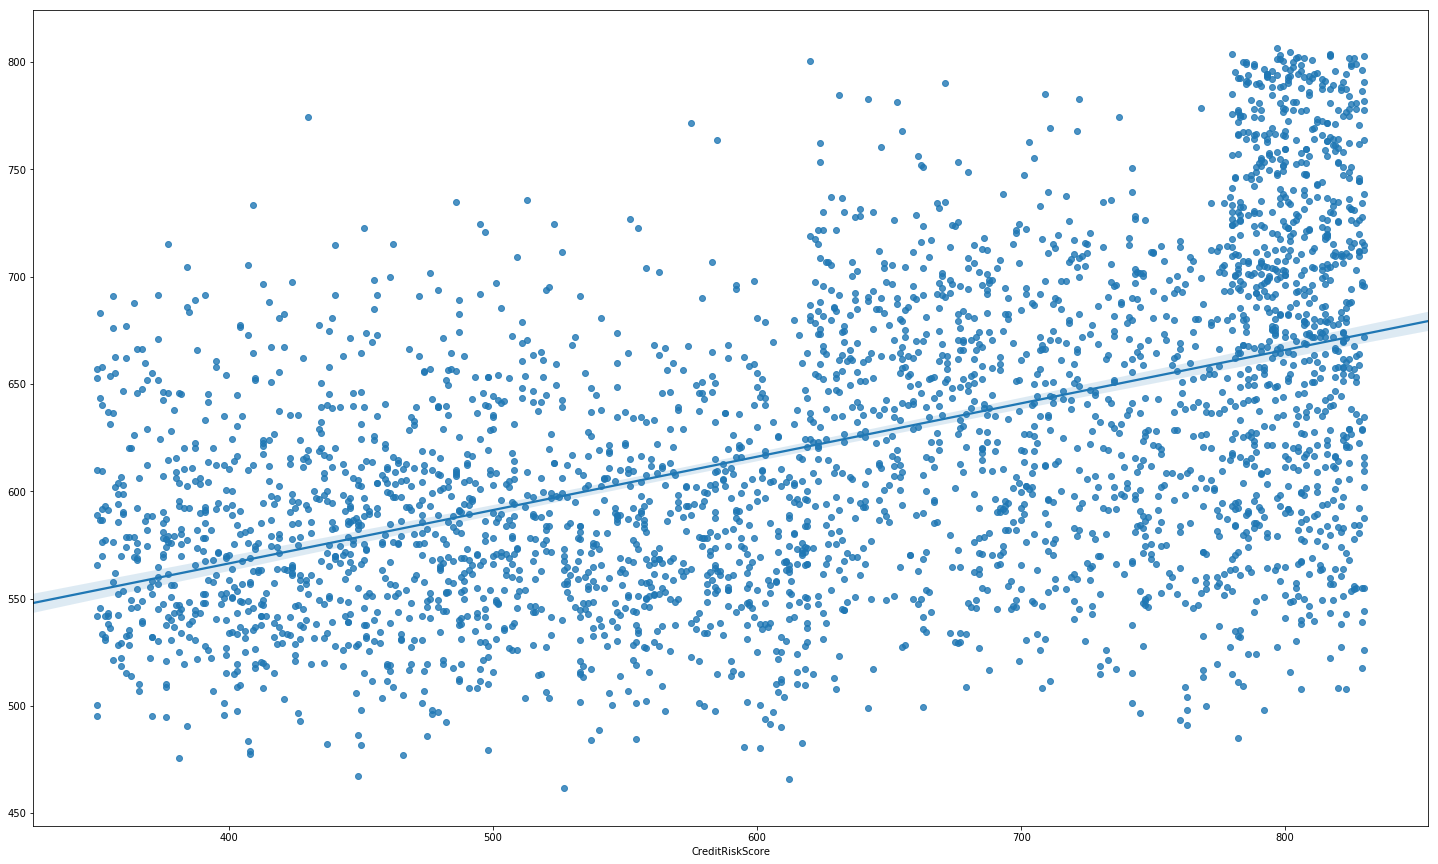

In [39]:
#predicting on the validation set 
y_test_pred = knnmodel.predict(X_test)

import seaborn as sns
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 25, 15

sns.regplot(y_test,y_test_pred)

In [40]:
print('\nRoot Mean Square Error = ', mean_squared_error(y_test,y_test_pred)**0.5)


Root Mean Square Error =  127.54682934855221


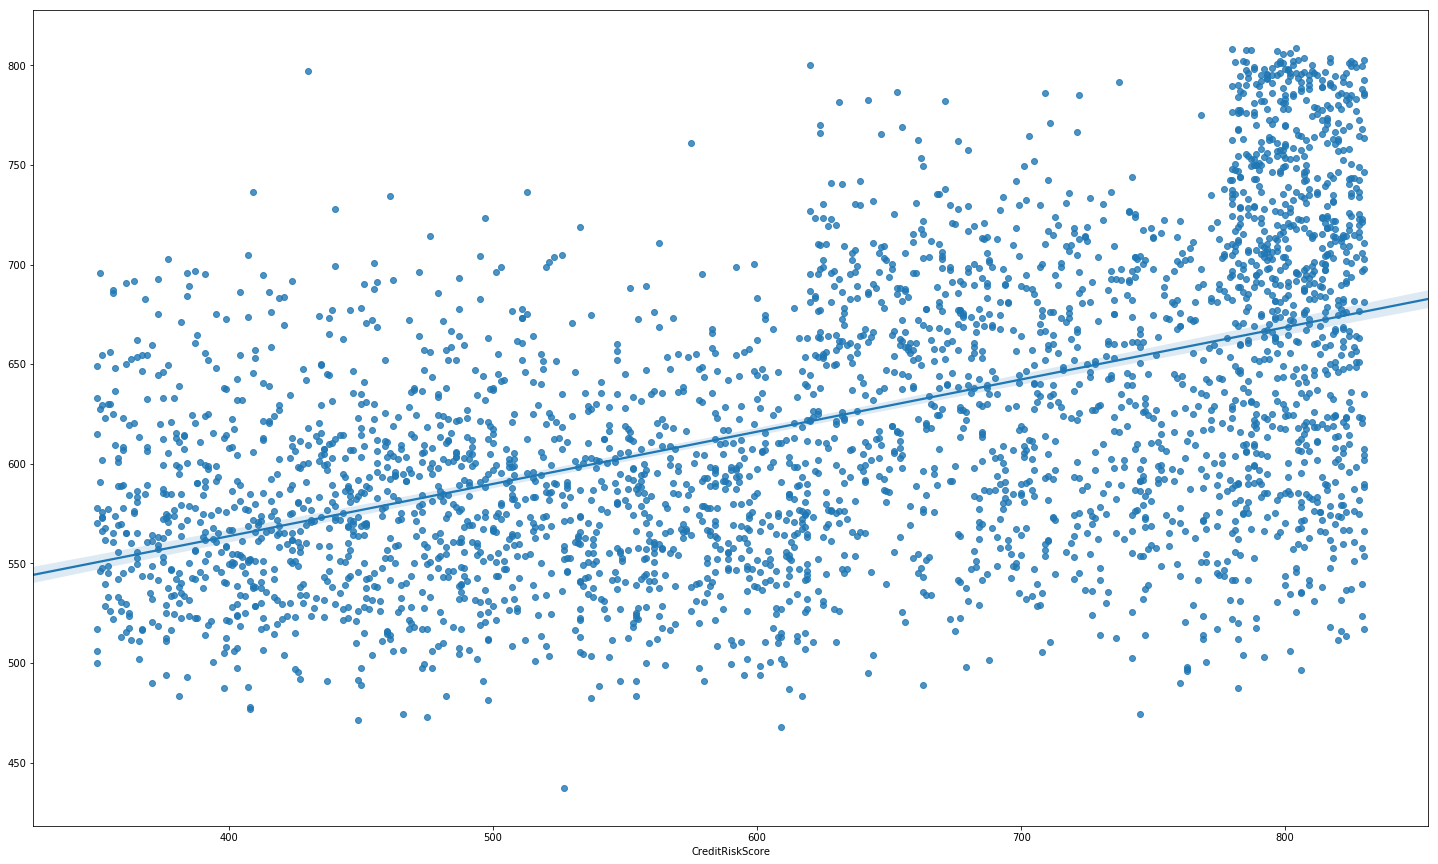

In [41]:
#predicting on the validation set 
y_test_pred = knnmodelwt.predict(X_test)

import seaborn as sns
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 25, 15

sns.regplot(y_test,y_test_pred)

In [42]:
print('\nRoot Mean Square Error = ', mean_squared_error(y_test,y_test_pred)**0.5)


Root Mean Square Error =  126.3526863697355


# Insights from Linear regression done in R

### Linear regression results using all features 
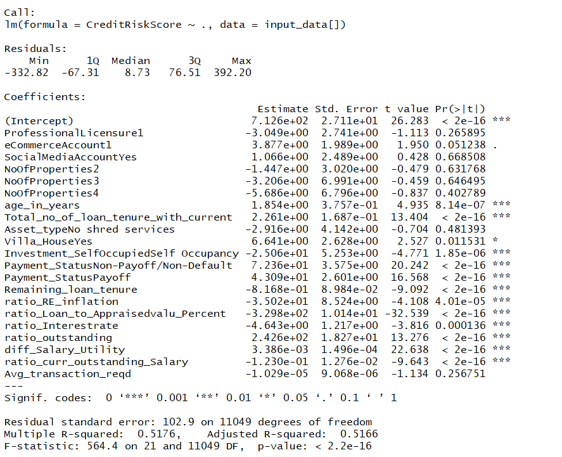

### Preforforming stepAIC for feature selection. The final result with minimum AIC which means minimum residual is as given below:
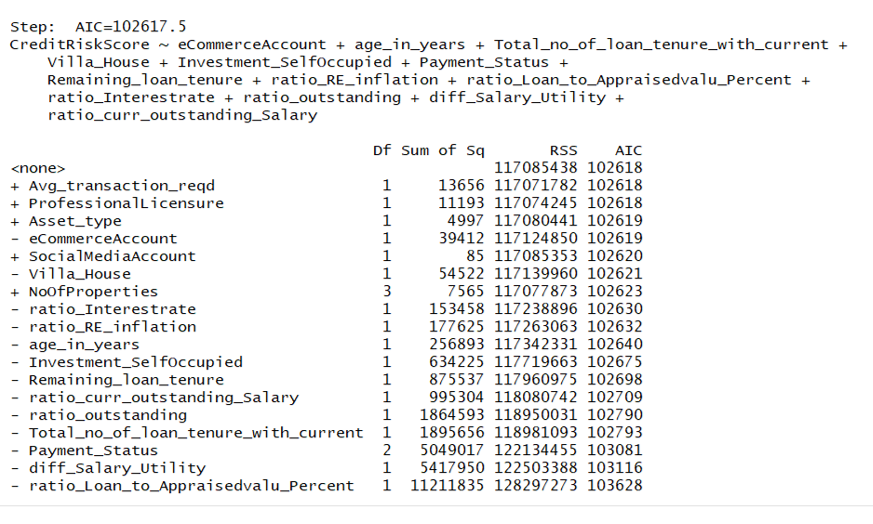

### Linear regression result considering the features select using the stepAIC result
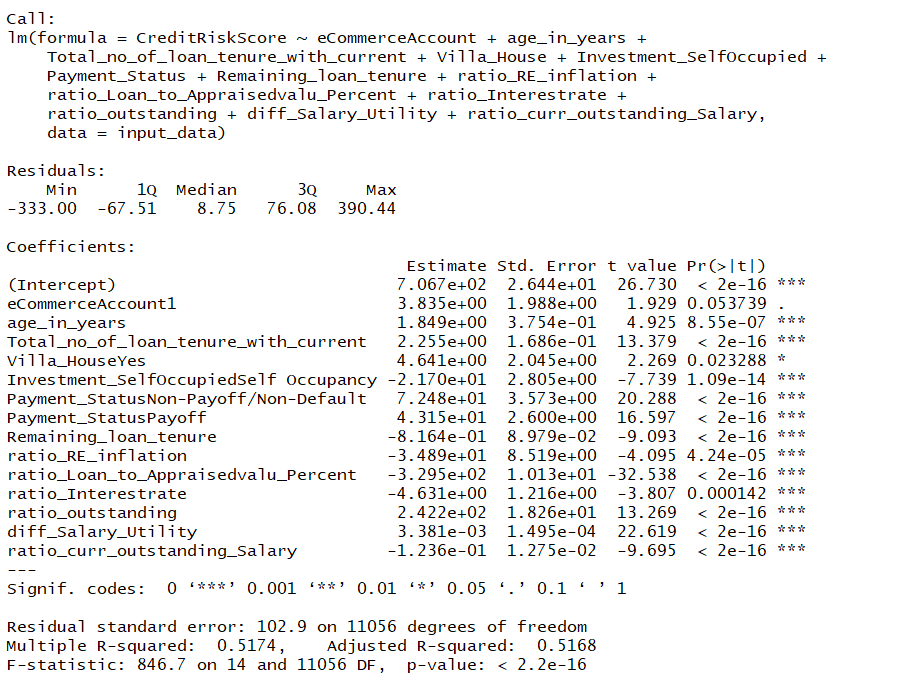

# Performing KNN again dropping non-signifcant features

In [43]:
trainDF_ohe.columns

Index(['age_in_years', 'Total_no_of_loan_tenure_with_current',
       'Remaining_loan_tenure', 'ratio_RE_inflation',
       'ratio_Loan_to_Appraisedvalu_Percent', 'ratio_Interestrate',
       'ratio_outstanding', 'diff_Salary_Utility',
       'ratio_curr_outstanding_Salary', 'Avg_transaction_reqd',
       'ProfessionalLicensure_1', 'eCommerceAccount_1', 'NoOfProperties_2',
       'NoOfProperties_3', 'NoOfProperties_4', 'SocialMediaAccount_Yes',
       'Asset_type_No shred services', 'Villa_House_Yes',
       'Investment_SelfOccupied_Self Occupancy',
       'Payment_Status_Non-Payoff/Non-Default', 'Payment_Status_Payoff'],
      dtype='object')

In [44]:
ll = []
for col in trainDF_ohe.columns:
    if col.startswith('Prof') | col.startswith('Soci') | col.startswith('Asse') | col.startswith('NoOfP') | col.startswith('Avg_tr'):
        ll.append(col)
ll

['Avg_transaction_reqd',
 'ProfessionalLicensure_1',
 'NoOfProperties_2',
 'NoOfProperties_3',
 'NoOfProperties_4',
 'SocialMediaAccount_Yes',
 'Asset_type_No shred services']

In [45]:
trainDF_ohe.drop(ll, axis=1,inplace=True)

In [46]:
trainDF_ohe.columns

Index(['age_in_years', 'Total_no_of_loan_tenure_with_current',
       'Remaining_loan_tenure', 'ratio_RE_inflation',
       'ratio_Loan_to_Appraisedvalu_Percent', 'ratio_Interestrate',
       'ratio_outstanding', 'diff_Salary_Utility',
       'ratio_curr_outstanding_Salary', 'eCommerceAccount_1',
       'Villa_House_Yes', 'Investment_SelfOccupied_Self Occupancy',
       'Payment_Status_Non-Payoff/Non-Default', 'Payment_Status_Payoff'],
      dtype='object')

In [47]:
## now do the OLS
from sklearn.model_selection import train_test_split
## The target varialbe from the train data has already been taken out. Save it as Y
Y = target
X = trainDF_ohe

# log transform the Y variable (Left/negatively skewed)
# Y = np.log10(831-Y)

## if you want to use the sqrt transform
# Y = np.sqrt(851-Y)

# split data into train and test sets
seed = 7
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)  ## train_test_split() is from sklearn

In [48]:
# look at the error rate for different k values

#import required packages
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline

In [49]:
from sklearn.model_selection import GridSearchCV

GRID_SEARCH = False

if GRID_SEARCH:

    neighList = [i for i in range(20,40)]
    leafSizeList = [10,20,30,40]
    p_list = [i for i in range(1,4)]
    params = {'n_neighbors':neighList,'leaf_size':leafSizeList,'p':p_list}
else:
    neighList = [21]
    leafSizeList = [10]
    p_list = [1]
    params = {'n_neighbors':neighList,'leaf_size':leafSizeList,'p':p_list}


knn_new = neighbors.KNeighborsRegressor(n_jobs=4)
knnmodel_new = GridSearchCV(knn_new, params, cv=5)
knnmodel_new.fit(X_train,y_train)
knnmodel_new.best_params_

{'leaf_size': 10, 'n_neighbors': 21, 'p': 1}

In [50]:
from sklearn.model_selection import GridSearchCV

if GRID_SEARCH:

    neighList = [i for i in range(20,40)]
    leafSizeList = [10,20,30,40]
    p_list = [i for i in range(1,4)]
    params = {'n_neighbors':neighList,'leaf_size':leafSizeList,'p':p_list}
else:
    neighList = [21]
    leafSizeList = [10]
    p_list = [1]
    params = {'n_neighbors':neighList,'leaf_size':leafSizeList,'p':p_list}


knnwt_new = neighbors.KNeighborsRegressor(weights="distance",n_jobs=4)
knnmodelwt_new = GridSearchCV(knnwt_new, params, cv=5)
knnmodelwt_new.fit(X_train,y_train)
knnmodelwt_new.best_params_

{'leaf_size': 10, 'n_neighbors': 21, 'p': 1}

In [51]:
# rmse_val = [] #to store rmse values for different k
# for K in range(100):
#     K = K+1
#     model = neighbors.KNeighborsRegressor(n_neighbors = K)

#     model.fit(X_train, y_train)  #fit the model
#     pred=model.predict(X_test) #make prediction on test set
#     error = sqrt(mean_squared_error(y_test,pred)) #calculate rmse
#     rmse_val.append(error) #store rmse values
#     print('RMSE value for k= ' , K , 'is:', error)

In [52]:
# #plotting the rmse values against k values
# rcParams['figure.figsize'] = 10, 8
# curve = pd.DataFrame(rmse_val) #elbow curve 
# curve.plot()

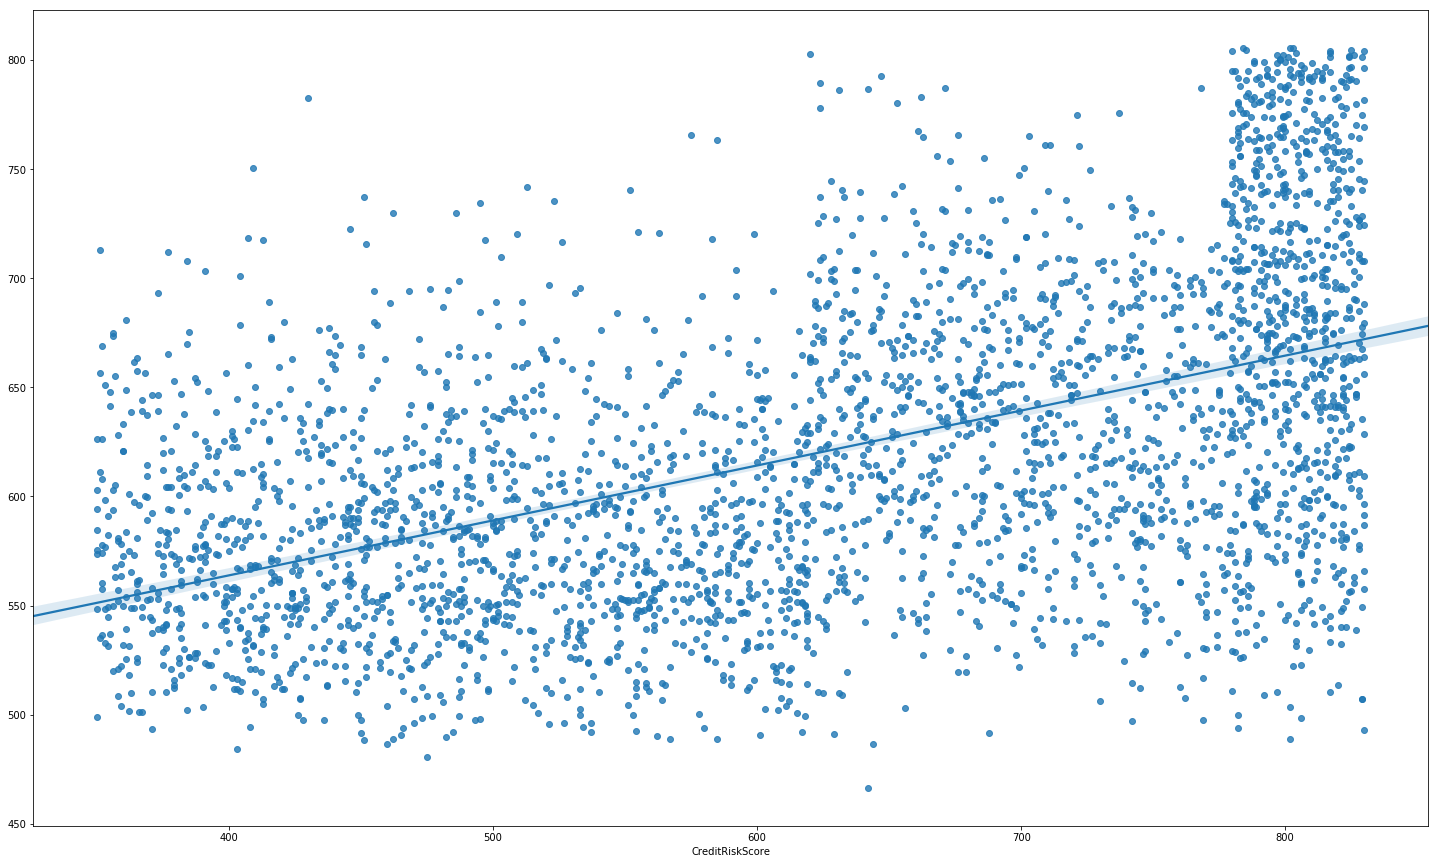

In [53]:
#predicting on the validation set 
y_test_pred = knnmodel_new.predict(X_test)

import seaborn as sns
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 25, 15

sns.regplot(y_test,y_test_pred)

In [54]:
print('\nRoot Mean Square Error = ', mean_squared_error(y_test,y_test_pred)**0.5)


Root Mean Square Error =  127.21726822579959


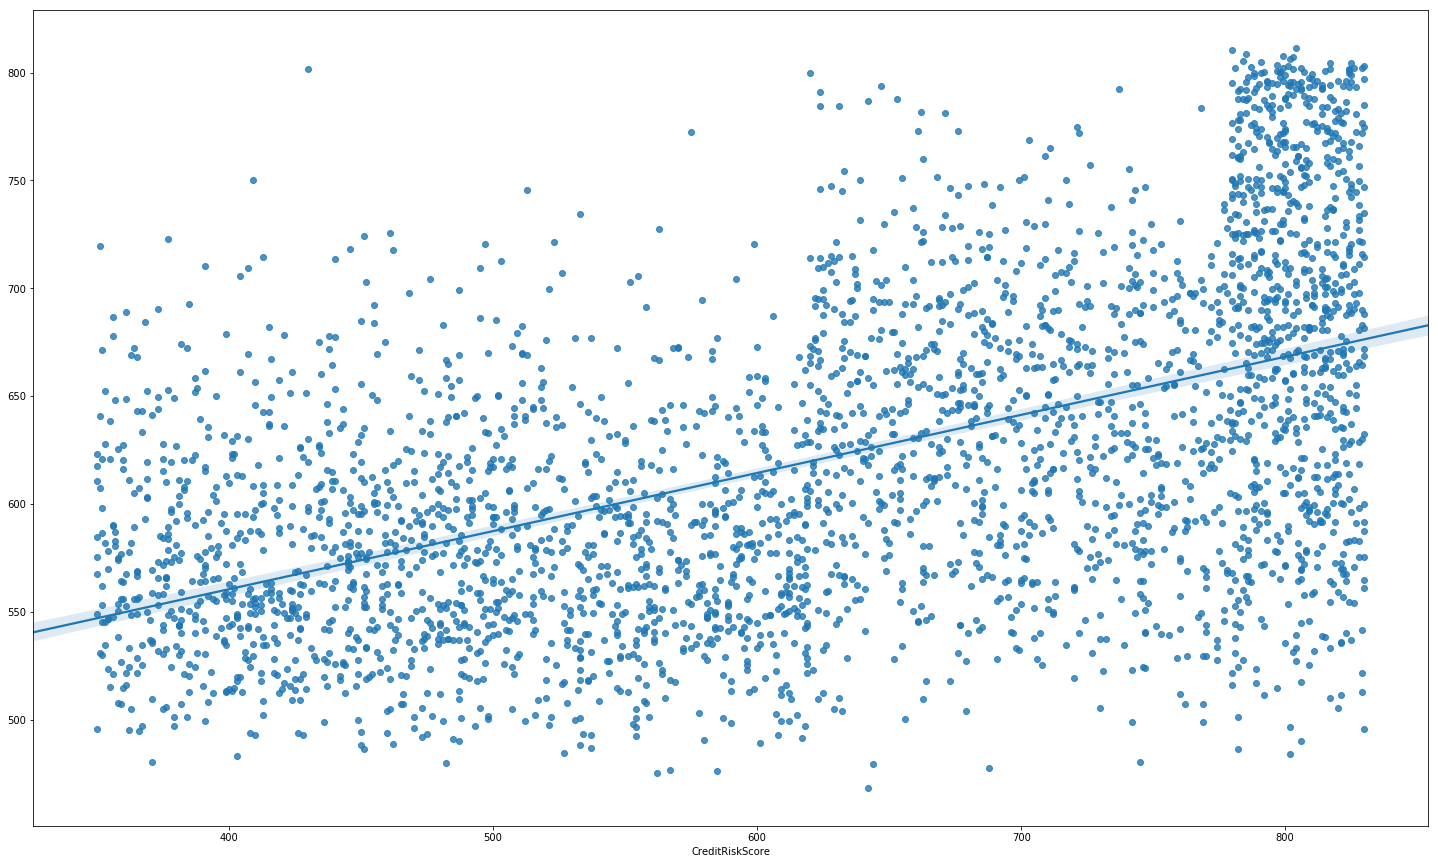

In [55]:
#predicting on the validation set 
y_test_pred = knnmodelwt_new.predict(X_test)

import seaborn as sns
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 25, 15

sns.regplot(y_test,y_test_pred)

In [56]:
print('\nRoot Mean Square Error = ', mean_squared_error(y_test,y_test_pred)**0.5)


Root Mean Square Error =  125.71683518444723


# Predictions

#### Reading both the train datasets

**1. Test-1557294637283 : Dataset of Customer demographics including the target attribute(CreditRiskScore)**

**2. Test_PaymentHistory-1557294848030 : Dataset of payment history**

In [57]:
unseenDataDF_PayHist = pd.read_excel("../Data/Test_PaymentHistory-1557294848030.xlsx")
unseenDataDF_CreditRisk = pd.read_excel("../Data/Test-1557294637283.xlsx")

print("Shape of unseenDataDF_PayHist is " + str(unseenDataDF_PayHist.shape))
print("Shape of unseenDataDF_CreditRisk is " + str(unseenDataDF_CreditRisk.shape))

Shape of unseenDataDF_PayHist is (67621, 19)
Shape of unseenDataDF_CreditRisk is (2774, 8)


### Transforming the unseen data like the train data

## Feature Engineering 1
### Adding new features

#### First on the payment history data set

In [58]:
if CUSTOM_FEATURES:
    ## Calculate age using DOB
    unseenDataDF_CreditRisk['DOB'] = pd.to_datetime(unseenDataDF_CreditRisk['DOB'], format="%Y-%m-%d")
    
    # create a column with today's date time
    unseenDataDF_CreditRisk['today'] = DateTime.today()
    # Create timeDiff as difference between today and your Datetime column
    unseenDataDF_CreditRisk['timeDiff'] = unseenDataDF_CreditRisk.today - unseenDataDF_CreditRisk['DOB']
    
    # Create age columns (remember to use only one at a time. start with age_in_years

    unseenDataDF_CreditRisk['age_in_days'] = unseenDataDF_CreditRisk.timeDiff.dt.days
    unseenDataDF_CreditRisk['age_in_years'] = (unseenDataDF_CreditRisk.timeDiff.dt.days/365).apply(lambda x: int(x))
    unseenDataDF_CreditRisk['age_in_months'] = (unseenDataDF_CreditRisk.timeDiff.dt.days/365*12).apply(lambda x: int(x))
        

    ## Calculate additional features
    unseenDataDF_PayHist['Loan_tenure_with_current'] = unseenDataDF_PayHist['Current_Instalment_Sequence'] - \
                                                    unseenDataDF_PayHist['Starting_Instalment'] + 1
    
    unseenDataDF_PayHist['Remaining_loan_tenure'] = unseenDataDF_PayHist['Maturity_Period'] - \
                                                    unseenDataDF_PayHist['Current_Instalment_Sequence']
    
    unseenDataDF_PayHist['loan_paid_off'] = unseenDataDF_PayHist['Starting_outstanding'] - \
                                        unseenDataDF_PayHist['Current_Outstanding']
    
    ## Group by the Customer ID
    unseenDataDF_PayHist_groupByCustID = unseenDataDF_PayHist.groupby('CustomerID')
    
    ## Sort the payment history dataframe by customerID and loan_tenure_with_current, then groupby customerID, then 
    ## diff() the loan_paid_off column. This will give a new column
    unseenDataDF_PayHist['loan_paid_in_transaction'] = unseenDataDF_PayHist.sort_values(['CustomerID','Loan_tenure_with_current'])\
                                        .groupby('CustomerID')['loan_paid_off'].diff()
    
    unseenDataDF_PayHist['ratio_RE_inflation'] = unseenDataDF_PayHist['RealEstate_Current_Inflation']/unseenDataDF_PayHist['RealEstate_Starting_Inflation']
    
    unseenDataDF_PayHist['ratio_Loan_to_Appraisedvalu_Percent'] = unseenDataDF_PayHist['Current_Loan_to_Appraisedvalu_Percent']/unseenDataDF_PayHist['Starting_Loan_to_Appraisedvalu_Percent']
    
    unseenDataDF_PayHist['ratio_Interestrate'] = unseenDataDF_PayHist['CurrentInterestrate']/unseenDataDF_PayHist['StartingInterestrate']
    
    unseenDataDF_PayHist['ratio_outstanding'] = unseenDataDF_PayHist['Current_Outstanding']/unseenDataDF_PayHist['Starting_outstanding']
    
    

In [59]:
unseenDataDF_PayHist.head()

,CustomerID,Current_Instalment_Sequence,Starting_Instalment,Maturity_Period,Current_Outstanding,Current_Loan_to_Appraisedvalu_Percent,CurrentInterestrate,RealEstate_Current_Inflation,GDP,UnemploymentRate,...,RealEstate_Starting_Inflation,Payment_Status,Loan_tenure_with_current,Remaining_loan_tenure,loan_paid_off,loan_paid_in_transaction,ratio_RE_inflation,ratio_Loan_to_Appraisedvalu_Percent,ratio_Interestrate,ratio_outstanding
0,C41116,25,25,119,61031.10,33.911009,10.500,2.2629,2.899137,4.7,...,0.9799,Non-Payoff/Non-Default,1,94,2718.90,NaN,2.309317,0.414560,1.000000,0.957351
1,C41116,26,25,119,60882.42,34.007232,10.500,2.2510,2.151365,4.7,...,0.9799,Non-Payoff/Non-Default,2,93,2867.58,148.68,2.297173,0.415736,1.000000,0.955018
2,C41116,27,25,119,60729.80,34.335349,10.500,2.2239,2.361722,4.4,...,0.9799,Non-Payoff/Non-Default,3,92,3020.20,152.62,2.269517,0.419748,1.000000,0.952624
3,C41116,28,25,119,60576.14,34.672545,10.875,2.1967,1.229172,4.6,...,0.9799,Non-Payoff/Non-Default,4,91,3173.86,153.66,2.241759,0.423870,1.035714,0.950214
4,C41116,29,25,119,60424.39,34.951639,10.875,2.1737,1.692969,4.5,...,0.9799,Non-Payoff/Non-Default,5,90,3325.61,151.75,2.218288,0.427282,1.035714,0.947834


## Feature Engineering 2
### Aggregating features from unseenDataDF_PayHist to merge them with unseenDataDF_CreditRisk in a seperate dataframe named unseenfinalDF

#### Aggregating by Count: 
For every customer, selecting total number of trasactions with the currect company

In [60]:
# Aggregating 'Loan_tenure_with_current' by count, renaming it to 'Total_no_of_loan_tenure_with_current' and merging it with finalDF

unseenDataDF_PayHist_transactionPerCust = unseenDataDF_PayHist.groupby('CustomerID').agg({'Loan_tenure_with_current':'count'})
## need to reset the index because the agg() operation sets the index of the resulting data frame as the column on
## which the grouping has been done
unseenDataDF_PayHist_transactionPerCust.reset_index(inplace=True)
unseenDataDF_PayHist_transactionPerCust.rename(index=str, columns={"Loan_tenure_with_current": "Total_no_of_loan_tenure_with_current"}, inplace=True)
# trainDF_PayHist_transactionPerCust.head()

# Now, join the above two data frames with the Credit Risk table with the Customer ID as the join-on column

unseenfinalDF = deepcopy(unseenDataDF_CreditRisk)


unseenfinalDF = unseenfinalDF.merge(unseenDataDF_PayHist_transactionPerCust,how='left',left_on = 'CustomerID',\
                      right_on='CustomerID',left_index=False, right_index=False)
# unseenfinalDF.head()

#### Aggregating by taking last values:
Selecting only the last value for all categorical variables

In [61]:
unseenDataDF_PayHist_CategCols = unseenDataDF_PayHist.select_dtypes('object')
# unseenDataDF_PayHist_CategCols.head()

unseenDataDF_PayHist_CategCols_lastVals = unseenDataDF_PayHist_CategCols.groupby('CustomerID').agg('last').reset_index()
# unseenDataDF_PayHist_CategCols_lastVals.head()

# Now, join the data frame with last values of categorical columns to the finalDF table containing the
# credit risk data with the Customer ID as the join-on column

unseenfinalDF = unseenfinalDF.merge(unseenDataDF_PayHist_CategCols_lastVals,how='left',left_on = 'CustomerID',\
                      right_on='CustomerID',left_index=False, right_index=False)
unseenfinalDF.head()


# Selecting appropriate numerical columns from trainDF_PayHist which can be directly flattened using the latest value for 
# each customer (i.e. the value for the last instalment)

unseenDataDF_PayHist_NumericalCols_direct_flaten = unseenDataDF_PayHist[['CustomerID','Current_Instalment_Sequence', 'Starting_Instalment', 
                                                               'Maturity_Period', 'Current_Outstanding', 
                                                               'Current_Loan_to_Appraisedvalu_Percent', 
                                                               'RealEstate_Current_Inflation', 'Starting_outstanding',
                                                               'Starting_Loan_to_Appraisedvalu_Percent', 'StartingInterestrate',
                                                               'RealEstate_Starting_Inflation', 'Remaining_loan_tenure',
                                                               'loan_paid_off']]
# unseenDataDF_PayHist_NumericalCols_direct_flaten.head()

unseenDataDF_PayHist_NumericalCols_direct_flaten_lastVals = unseenDataDF_PayHist_NumericalCols_direct_flaten.\
                                                        groupby('CustomerID').\
                                                        agg('last').reset_index()

# unseenDataDF_PayHist_NumericalCols_direct_flaten_lastVals.head()

# Now, join the data frame with last values of categorical columns to the unseenfinalDF table containing the
# credit risk data with the Customer ID as the join-on column

unseenfinalDF = unseenfinalDF.merge(unseenDataDF_PayHist_NumericalCols_direct_flaten_lastVals,how='left',left_on = 'CustomerID',\
                      right_on='CustomerID',left_index=False, right_index=False)
unseenfinalDF.head()

,CustomerID,DOB,Salary,ProfessionalLicensure,UtilitySpending,eCommerceAccount,SocialMediaAccount,NoOfProperties,today,timeDiff,...,Maturity_Period,Current_Outstanding,Current_Loan_to_Appraisedvalu_Percent,RealEstate_Current_Inflation,Starting_outstanding,Starting_Loan_to_Appraisedvalu_Percent,StartingInterestrate,RealEstate_Starting_Inflation,Remaining_loan_tenure,loan_paid_off
0,C41116,1973-04-21,1876.0,1,396.161956,1,Yes,1,2019-05-17 13:37:02.843499,16827 days 13:37:02.843499,...,119,52686.35,34.898842,1.8982,63750.0,81.8,10.500,0.9799,59,11063.65
1,C41117,1970-03-14,1261.0,0,195.604966,0,No,1,2019-05-17 13:37:02.843499,17961 days 13:37:02.843499,...,106,20092.00,12.903769,1.8982,35100.0,54.6,8.990,0.7837,46,15008.00
2,C41118,1981-01-03,1026.0,1,212.937051,0,Yes,2,2019-05-17 13:37:02.843499,14013 days 13:37:02.843499,...,141,83836.02,79.521757,1.8982,92800.0,80.0,8.200,2.0886,81,8963.98
3,C41119,1983-01-04,1384.0,0,396.161956,1,Yes,1,2019-05-17 13:37:02.843499,13282 days 13:37:02.843499,...,142,155180.90,91.271715,1.8982,165000.0,88.2,7.500,2.0886,82,9819.10
4,C41120,1979-03-16,1913.0,1,220.365088,1,Yes,2,2019-05-17 13:37:02.843499,14672 days 13:37:02.843499,...,142,58520.11,78.598409,1.8982,67000.0,78.8,6.975,2.1677,82,8479.89


#### Aggregating by taking mean/median:
Selecting only the median values of all the given below features

In [62]:
## ENVIRONMENT VARIABLES FOR AGGREGATION

## Setting for choosing the aggregation metric to be either MEAN or MEDIAN

# AGG_NUMERIC_METRIC = 'mean' ## choose either 'median' or 'mean'

thelist_avg_values = ['CustomerID', 'CurrentInterestrate', 'GDP', 'UnemploymentRate', 'ratio_RE_inflation',
                      'ratio_Loan_to_Appraisedvalu_Percent','ratio_Interestrate', 'ratio_outstanding', 'loan_paid_in_transaction']


unseenDataDF_PayHist_NumericalCols_avg = unseenDataDF_PayHist[thelist_avg_values]

unseenDataDF_PayHist_NumericalCols_flaten_avg = unseenDataDF_PayHist_NumericalCols_avg.\
                                                        groupby('CustomerID').\
                                                        agg(AGG_NUMERIC_METRIC).reset_index()

unseenDataDF_PayHist_NumericalCols_flaten_avg.head()


unseenfinalDF = unseenfinalDF.merge(unseenDataDF_PayHist_NumericalCols_flaten_avg,how='left',left_on = 'CustomerID',\
                      right_on='CustomerID',left_index=False, right_index=False)

unseenfinalDF.rename(index=str, columns={"loan_paid_in_transaction": "Avg_loan_paid_in_transaction"}, inplace=True)

unseenfinalDF.head()

,CustomerID,DOB,Salary,ProfessionalLicensure,UtilitySpending,eCommerceAccount,SocialMediaAccount,NoOfProperties,today,timeDiff,...,Remaining_loan_tenure,loan_paid_off,CurrentInterestrate,GDP,UnemploymentRate,ratio_RE_inflation,ratio_Loan_to_Appraisedvalu_Percent,ratio_Interestrate,ratio_outstanding,Avg_loan_paid_in_transaction
0,C41116,1973-04-21,1876.0,1,396.161956,1,Yes,1,2019-05-17 13:37:02.843499,16827 days 13:37:02.843499,...,59,11063.65,10.500,1.717053,7.3,1.767221,0.527847,1.0,0.909024,229.055
1,C41117,1970-03-14,1261.0,0,195.604966,0,No,1,2019-05-17 13:37:02.843499,17961 days 13:37:02.843499,...,46,15008.00,8.990,1.717053,7.3,2.209647,0.340091,1.0,0.738588,274.935
2,C41118,1981-01-03,1026.0,1,212.937051,0,Yes,2,2019-05-17 13:37:02.843499,14013 days 13:37:02.843499,...,81,8963.98,8.200,1.717053,7.3,0.829120,1.176559,1.0,0.956341,270.855
3,C41119,1983-01-04,1384.0,0,396.161956,1,Yes,1,2019-05-17 13:37:02.843499,13282 days 13:37:02.843499,...,82,9819.10,7.500,1.717053,7.3,0.829120,1.184586,1.0,0.971953,256.810
4,C41120,1979-03-16,1913.0,1,220.365088,1,Yes,2,2019-05-17 13:37:02.843499,14672 days 13:37:02.843499,...,82,8479.89,6.975,1.717053,7.3,0.798865,1.216488,1.0,0.946032,201.495


## Feature Engineering 3
### Adding new features to finalDF
### Dropping features which are not required

In [63]:
if CUSTOM_FEATURES:
    unseenfinalDF['diff_Salary_Utility'] = unseenfinalDF['Salary'] - unseenfinalDF['UtilitySpending']
        
    unseenfinalDF['ratio_curr_outstanding_Salary'] = unseenfinalDF['Current_Outstanding']/unseenfinalDF['Salary']
    
    unseenfinalDF['Avg_transaction_reqd'] = unseenfinalDF['loan_paid_off']/unseenfinalDF['Avg_loan_paid_in_transaction']
    
    unseenfinalDF.drop(['DOB', 'today','timeDiff','age_in_days', 'age_in_months'], axis=1,inplace=True)
    
    unseenfinalDF.drop(['Salary','UtilitySpending', 'Current_Outstanding', 'loan_paid_off', 'Avg_loan_paid_in_transaction'], axis=1, inplace=True)
    
    unseenfinalDF.drop(['RealEstate_Current_Inflation', 'RealEstate_Starting_Inflation'], axis=1, inplace=True)
    
    unseenfinalDF.drop(['Current_Loan_to_Appraisedvalu_Percent','Starting_Loan_to_Appraisedvalu_Percent'], axis=1, inplace=True)
    
    unseenfinalDF.drop(['CurrentInterestrate','StartingInterestrate'], axis=1, inplace=True)
    
    unseenfinalDF = unseenfinalDF.replace([np.inf,-np.inf],np.nan)
    
    unseenfinalDF.drop(['UnemploymentRate','GDP', 'Urban_Development'], axis=1, inplace=True)
    
    


In [64]:
FEATURE_DROP = True

if FEATURE_DROP:
    unseenfinalDF.drop(['Avg_transaction_reqd','ProfessionalLicensure', 'NoOfProperties', 'SocialMediaAccount', 'Asset_type'],\
                       axis=1, inplace=True)

In [65]:
unseenfinalDF.isnull().sum()

# finalDF = finalDF.dropna()

CustomerID                                0
eCommerceAccount                          0
age_in_years                              0
Total_no_of_loan_tenure_with_current      0
Villa_House                               0
Investment_SelfOccupied                   0
Payment_Status                            0
Current_Instalment_Sequence               0
Starting_Instalment                       0
Maturity_Period                           0
Starting_outstanding                      0
Remaining_loan_tenure                     0
ratio_RE_inflation                        0
ratio_Loan_to_Appraisedvalu_Percent       0
ratio_Interestrate                      369
ratio_outstanding                         0
diff_Salary_Utility                       0
ratio_curr_outstanding_Salary             0
dtype: int64

In [66]:
if REPLACE_NULL:
    df = unseenfinalDF.select_dtypes(include=np.number)
    df = df.apply(lambda x: x.fillna(value=np.mean(x)))
    
    for col in list(df.columns.values):
        unseenfinalDF[col] = df[col]
#     finalDF['ratio_Interestrate'] = finalDF['ratio_Interestrate'].fillna(value=np.mean(finalDF['ratio_Interestrate']))

else:
    unseenfinalDF.drop("ratio_Interestrate", axis=1, inplace=True)
    unseenfinalDF = unseenfinalDF.dropna()

In [67]:
unseenfinalDF.isnull().sum()

CustomerID                              0
eCommerceAccount                        0
age_in_years                            0
Total_no_of_loan_tenure_with_current    0
Villa_House                             0
Investment_SelfOccupied                 0
Payment_Status                          0
Current_Instalment_Sequence             0
Starting_Instalment                     0
Maturity_Period                         0
Starting_outstanding                    0
Remaining_loan_tenure                   0
ratio_RE_inflation                      0
ratio_Loan_to_Appraisedvalu_Percent     0
ratio_Interestrate                      0
ratio_outstanding                       0
diff_Salary_Utility                     0
ratio_curr_outstanding_Salary           0
dtype: int64

In [68]:
unseenDataDF = deepcopy(unseenfinalDF)

In [69]:
unseenDataDF.drop(['Starting_Instalment', 'Maturity_Period', 'Starting_outstanding',\
              'Current_Instalment_Sequence'], axis=1, inplace=True)

In [70]:
## store the Candidate.ID column of the train data
unseenId, unseenDataDF = outputID_dropID(unseenDataDF,id_col='CustomerID')  # this works well

In [71]:
# let's break down the columns by their type (i.e. int64, float64, object)
unseenDataDF.columns.to_series().groupby(unseenDataDF.dtypes).groups

{dtype('int64'): Index(['eCommerceAccount', 'age_in_years',
        'Total_no_of_loan_tenure_with_current', 'Remaining_loan_tenure'],
       dtype='object'),
 dtype('float64'): Index(['ratio_RE_inflation', 'ratio_Loan_to_Appraisedvalu_Percent',
        'ratio_Interestrate', 'ratio_outstanding', 'diff_Salary_Utility',
        'ratio_curr_outstanding_Salary'],
       dtype='object'),
 dtype('O'): Index(['Villa_House', 'Investment_SelfOccupied', 'Payment_Status'], dtype='object')}

# Transformations

In [72]:
# # Log transform substantially Left/negatively skewed features
# trainDF['ratio_outstanding'] = np.log10(2.16-trainDF['ratio_outstanding'])

# # Log transform substantially right/positively skewed features
# trainDF['diff_Salary_Utility'] = np.log10(trainDF['diff_Salary_Utility'])
# trainDF['ratio_curr_outstanding_Salary'] = np.log10(trainDF['ratio_curr_outstanding_Salary']+1)
# trainDF['ratio_RE_inflation'] = np.log10(trainDF['ratio_RE_inflation']+1)

# # Log transform moderately Left/negatively skewed features
# trainDF['ratio_Loan_to_Appraisedvalu_Percent'] = np.sqrt(1.75-trainDF['ratio_Loan_to_Appraisedvalu_Percent'])

# # Log transform moderately right/positively skewed features
# trainDF['Total_no_of_loan_tenure_with_current'] = np.sqrt(trainDF['Total_no_of_loan_tenure_with_current'])
# trainDF['Avg_transaction_reqd'] = np.sqrt(trainDF['Avg_transaction_reqd']+498)

# # trainDF['ratio_outstanding'].apply(lambda x: np.log10(2.16-x)).hist()
# trainDF['Avg_transaction_reqd'].hist()#.apply(lambda x: np.log10(x)).hist()
# # # trainDF['diff_Salary_Utility'].apply(lambda x: np.log10(x)).hist()#
# # # trainDF['ratio_curr_outstanding_Salary'].apply(lambda x: np.log10(x+1)).hist()#
# # # trainDF['ratio_RE_inflation'].apply(lambda x: np.log10(x+1)).hist()#
# # # trainDF['ratio_Loan_to_Appraisedvalu_Percent'].apply(lambda x: np.sqrt(1.73-x)).hist()#
# # trainDF['Total_no_of_loan_tenure_with_current'].apply(lambda x: np.sqrt(x)).hist()#

# # # df["ibu"].apply(np.log).hist()
# plt.show()

# Scaling

In [73]:
# for col in unseenDataDF.columns:
#     if (is_float_dtype(unseenDataDF[col])):
#         unseenDataDF[col] = scaler.fit_transform(np.array(unseenDataDF[col].values).reshape(-1,1))


# unseenDataDF.head()

# KNN

In [74]:
### convert numerical categorical columns as object type
for col in categorical_cols_num:
    if col in unseenDataDF.columns:
        unseenDataDF[col] = unseenDataDF[col].astype('object')
    else:
        categorical_cols_num.remove(col)
print(categorical_cols_num)
    

['eCommerceAccount']


In [75]:
# let's break down the columns by their type (i.e. int64, float64, object)
unseenDataDF.columns.to_series().groupby(unseenDataDF.dtypes).groups

{dtype('int64'): Index(['eCommerceAccount', 'age_in_years',
        'Total_no_of_loan_tenure_with_current', 'Remaining_loan_tenure'],
       dtype='object'),
 dtype('float64'): Index(['ratio_RE_inflation', 'ratio_Loan_to_Appraisedvalu_Percent',
        'ratio_Interestrate', 'ratio_outstanding', 'diff_Salary_Utility',
        'ratio_curr_outstanding_Salary'],
       dtype='object'),
 dtype('O'): Index(['Villa_House', 'Investment_SelfOccupied', 'Payment_Status'], dtype='object')}

In [76]:
# unseenDataDF.drop(['Avg_loan_paid_in_transaction', 'RealEstate_Starting_Inflation'], axis = 1, inplace=True)

# One Hot Encoding for KNN

In [77]:
for col in categorical_cols:
    for col in categorical_cols:
        if col not in unseenDataDF.columns:
            categorical_cols.remove(col)
print(categorical_cols)
    

['eCommerceAccount', 'Villa_House', 'Investment_SelfOccupied', 'Payment_Status']


In [78]:
### OneHotEncode the Object columns (dummify):

just_dummies = pd.get_dummies(unseenDataDF[categorical_cols],drop_first=True)

test = unseenDataDF.drop(categorical_cols,axis=1)
unseenDataDF_ohe = pd.concat([test, just_dummies], axis=1)

In [79]:
unseenDataDF_ohe
# let's break down the columns by their type (i.e. int64, float64, object)
unseenDataDF_ohe.columns.to_series().groupby(unseenDataDF_ohe.dtypes).groups

{dtype('uint8'): Index(['Villa_House_Yes', 'Investment_SelfOccupied_Self Occupancy',
        'Payment_Status_Non-Payoff/Non-Default', 'Payment_Status_Payoff'],
       dtype='object'),
 dtype('int64'): Index(['age_in_years', 'Total_no_of_loan_tenure_with_current',
        'Remaining_loan_tenure', 'eCommerceAccount'],
       dtype='object'),
 dtype('float64'): Index(['ratio_RE_inflation', 'ratio_Loan_to_Appraisedvalu_Percent',
        'ratio_Interestrate', 'ratio_outstanding', 'diff_Salary_Utility',
        'ratio_curr_outstanding_Salary'],
       dtype='object')}

In [80]:
# make predictions on unseen data

### Choose KNN model
the_knn_model = knnmodelwt_new
targetUnseenPred = the_knn_model.predict(unseenDataDF_ohe)

In [81]:
finalPredDF = pd.DataFrame()
finalPredDF['CustomerID'] = unseenId
finalPredDF['CreditRiskScore'] = targetUnseenPred #targetUnseenPred
# finalPredDF['CreditRiskScore'] = finalPredDF['CreditRiskScore'].apply(lambda x: int(x))
finalPredDF['CreditRiskScore'] = finalPredDF['CreditRiskScore'].apply(lambda x: math.ceil(x))
## convert the log10 values of prediction into actual values of target
# finalPredDF['CreditRiskScore'] = finalPredDF['CreditRiskScore'].apply(lambda x: 10**x)

# if you have used a sqrt transform:
# finalPredDF['CreditRiskScore'] = finalPredDF['CreditRiskScore'].apply(lambda x: 851-(x**2))

# finalPredDF.head()

In [82]:
## create the submission file

submissionDF = pd.read_csv("../Data/samplesubmission-1557545918238.csv")
submissionDF.drop(submissionDF.columns[1],axis=1,inplace=True)

submissionDF = submissionDF.merge(finalPredDF,how='left',left_on='CustomerID',right_on='CustomerID',left_index=False,right_index=False)
# submissionDF.drop(['ID'],axis=1,inplace=True)
# submissionDF.rename(columns={'prediction':'SalePrice'},inplace=True)
submissionDF.head()

,CustomerID,CreditRiskScore
0,C41116,768
1,C41117,793
2,C41118,663
3,C41119,595
4,C41120,686


In [83]:
from datetime import datetime as DateTime  # use this module just to get unique submission file names. See below
submissionFileName = "sanjyot_submission_knnFinal_" + (str(DateTime.now().time())[0:8]).replace(':','-') + '.csv'
submissionDF.to_csv(submissionFileName,index=False)

## Add a linear regression model on the same train, validation and test (unseen) data

In [84]:
from sklearn.linear_model import LinearRegression
linRegressor = LinearRegression()
linRegressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [85]:
X_train.head()

,age_in_years,Total_no_of_loan_tenure_with_current,Remaining_loan_tenure,ratio_RE_inflation,ratio_Loan_to_Appraisedvalu_Percent,ratio_Interestrate,ratio_outstanding,diff_Salary_Utility,ratio_curr_outstanding_Salary,eCommerceAccount_1,Villa_House_Yes,Investment_SelfOccupied_Self Occupancy,Payment_Status_Non-Payoff/Non-Default,Payment_Status_Payoff
8405,39,14,105,1.079514,0.909897,1.000000,0.982145,1367.108358,148.238071,1,0,0,0,0
4038,37,27,92,1.113156,0.167793,1.000000,0.160628,39747.084237,1.555835,1,0,1,0,1
9516,36,16,102,1.121879,0.875643,1.000000,0.971377,4865.814895,100.024346,0,1,1,0,1
10639,38,13,106,0.770102,1.232946,1.194273,0.986644,37190.444984,0.000000,0,1,1,0,1
11070,37,34,85,0.722279,1.325091,1.194273,0.977574,1493.443010,54.417881,1,1,1,1,0


In [86]:
data = {'Features':X_train.columns.values, 'Co-efficients':linRegressor.coef_} 
  
# Create DataFrame 
df = pd.DataFrame(data) 
  
# Print the output. 
df.sort_values(['Co-efficients'], ascending=False)

,Features,Co-efficients
6,ratio_outstanding,250.417060
12,Payment_Status_Non-Payoff/Non-Default,73.905207
13,Payment_Status_Payoff,45.749408
10,Villa_House_Yes,5.916149
9,eCommerceAccount_1,5.013345
1,Total_no_of_loan_tenure_with_current,2.326548
0,age_in_years,1.956723
7,diff_Salary_Utility,0.003397
8,ratio_curr_outstanding_Salary,-0.121043
2,Remaining_loan_tenure,-0.863834


In [87]:
from statsmodels.api import OLS
OLS(y_train,X_train).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        CreditRiskScore   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                 2.004e+04
Date:                Fri, 17 May 2019   Prob (F-statistic):               0.00
Time:                        13:37:04   Log-Likelihood:                -47107.
No. Observations:                7749   AIC:                         9.424e+04
Df Residuals:                    7735   BIC:                         9.434e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
age_in_years                               9.1465      0.319     28.695      0.000       8.522       9.771
Total_no_of_loan_tenure_with_current       4.3667      0.183     23.843      0.000       4.008       4.726
Remaining_loan_tenure                      0.1499      0.101      1.485      0.138      -0.048       0.348
ratio_RE_inflation                        44.8769      9.803      4.578      0.000      25.660      64.094
ratio_Loan_to_Appraisedvalu_Percent     -244.1074     11.783    -20.717      0.000    -267.205    -221.009
ratio_Interestrate                        -8.3909      1.465     -5.727      0.000     -11.263      -5.519
ratio_outstanding                        362.2030     22.008     16.458      0.000     319.062     405.344
diff_Salary_Utility                        0.0039      0.000     21.634      0.000       0.004       0.004
ratio_curr_outstanding_Salary             -0.1340      0.016     -8.335      0.000      -0.166      -0.103
eCommerceAccount_1                         5.5931      2.440      2.293      0.022       0.811      10.376
Villa_House_Yes                            8.3581      2.512      3.328      0.001       3.434      13.282
Investment_SelfOccupied_Self Occupancy   -20.2731      3.456     -5.865      0.000     -27.049     -13.498
Payment_Status_Non-Payoff/Non-Default     68.1880      4.362     15.632      0.000      59.637      76.739
Payment_Status_Payoff                     50.4008      3.178     15.861      0.000      44.172      56.630
==============================================================================
Omnibus:                      154.136   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              154.684
Skew:                          -0.323   Prob(JB):                     2.58e-34
Kurtosis:                       2.753   Cond. No.                     1.62e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.62e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

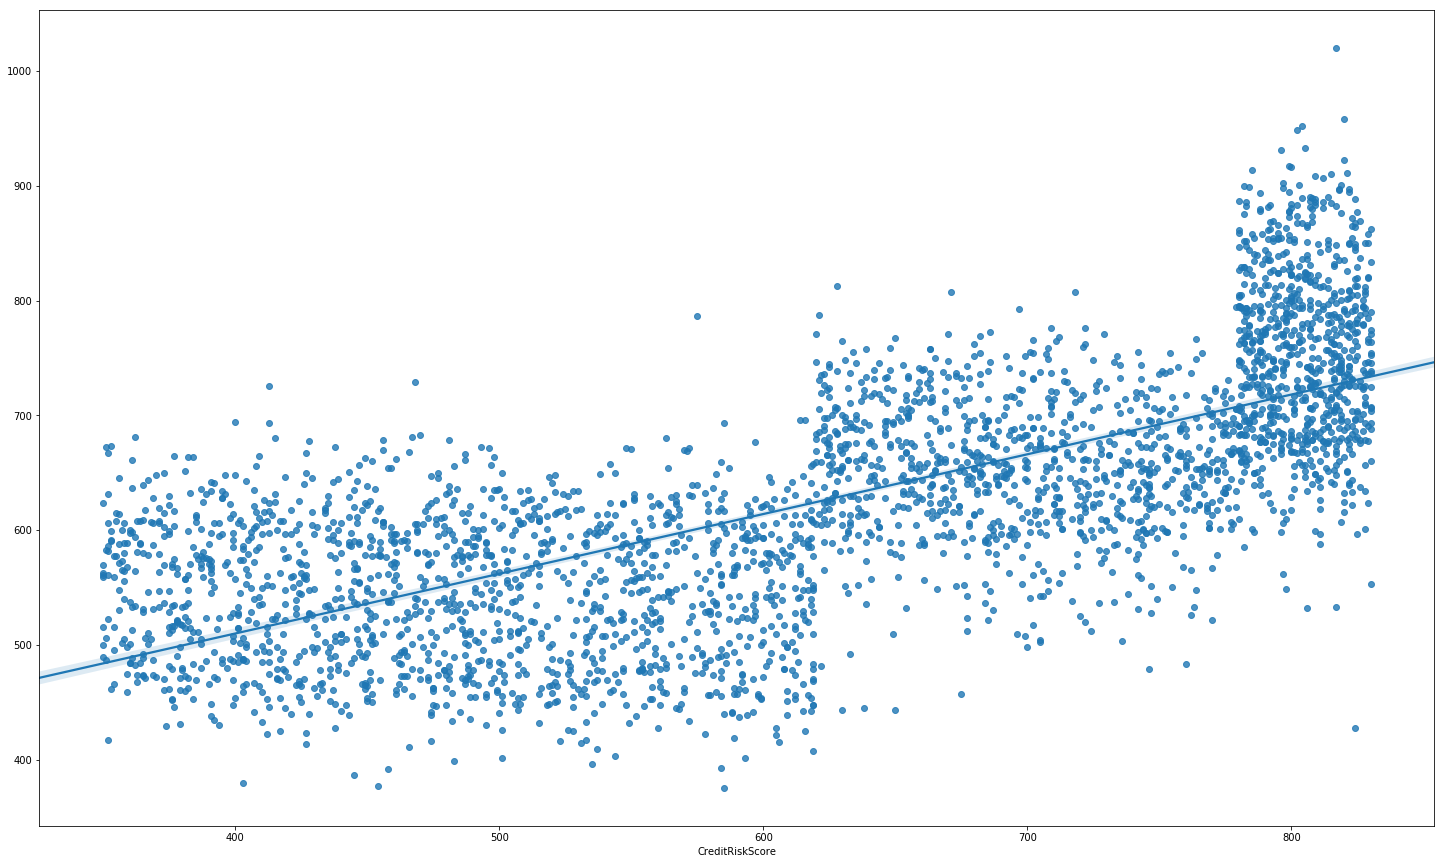

In [88]:
#predicting on the validation set 
y_test_pred_reg = linRegressor.predict(X_test)

import seaborn as sns
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 25, 15

sns.regplot(y_test,y_test_pred_reg)

In [89]:
print('\nRoot Mean Square Error = ', mean_squared_error(y_test,y_test_pred_reg)**0.5)


Root Mean Square Error =  103.80889012018956


In [90]:
COMBINE_KNN_LINREG=True

if COMBINE_KNN_LINREG:
    ### We want to take the mean of the prediction using knn and using lin reg
    combinedPredDF = pd.DataFrame()
    combinedPredDF['y_test_pred_knn'] = y_test_pred
    combinedPredDF['y_test_pred_linreg'] = y_test_pred_reg
    combinedPredDF['y_test_pred_mean_knn_linreg'] = combinedPredDF.mean(axis=1)

    y_test_pred_combined = combinedPredDF.y_test_pred_mean_knn_linreg
    print(combinedPredDF.head())

   y_test_pred_knn  y_test_pred_linreg  y_test_pred_mean_knn_linreg
0       524.421682          582.384047                   553.402864
1       555.818154          507.470137                   531.644146
2       644.969622          517.714639                   581.342130
3       549.797916          455.232562                   502.515239
4       751.624888          793.070104                   772.347496



Root Mean Square Error =  108.12741693373857


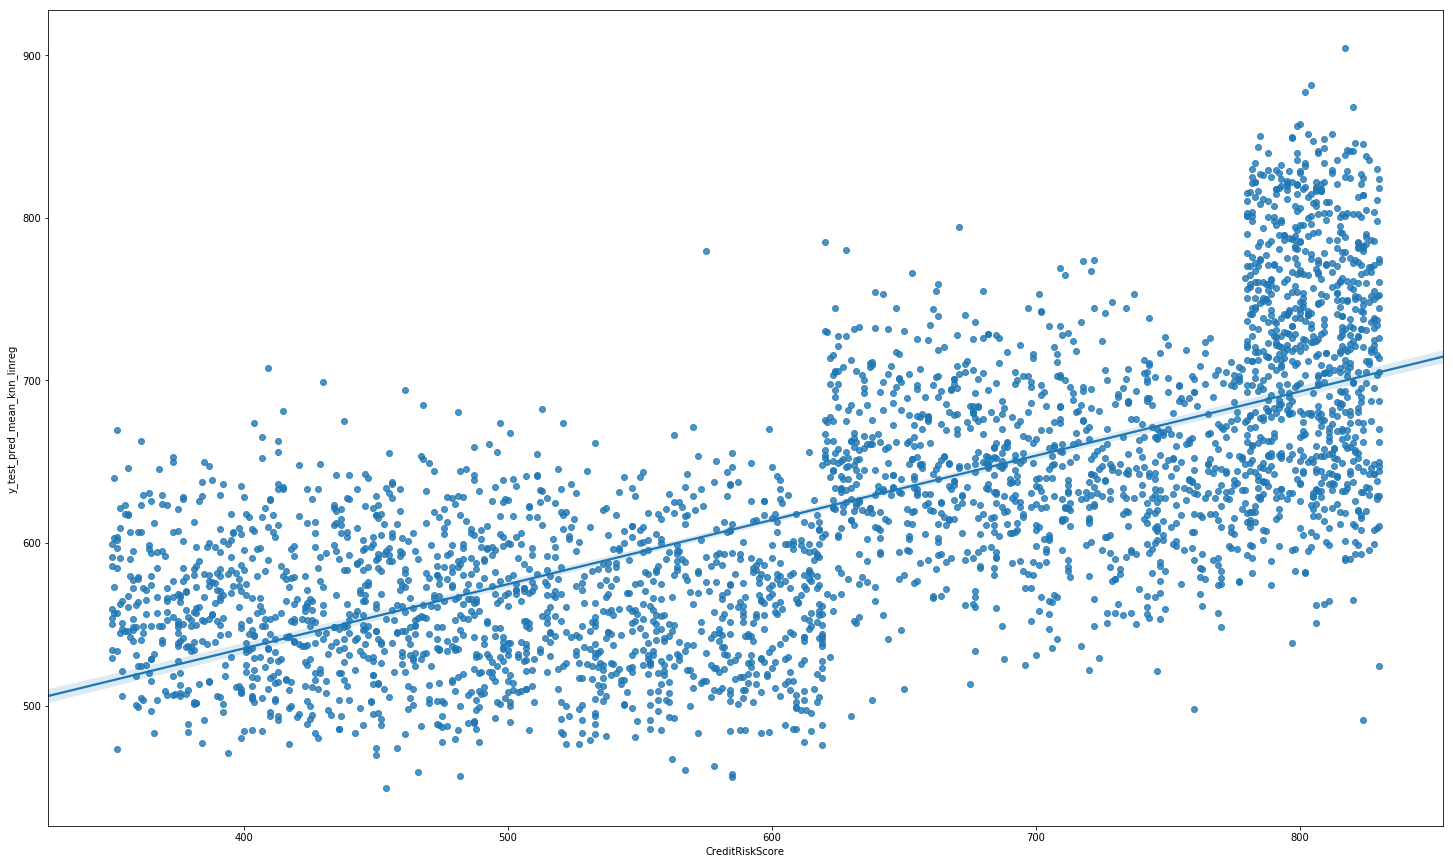

In [91]:
import seaborn as sns
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 25, 15

sns.regplot(y_test,y_test_pred_combined)
print('\nRoot Mean Square Error = ', mean_squared_error(y_test,y_test_pred_combined)**0.5)

### Predictions using linear regression

In [92]:
# make predictions on unseen data
targetUnseenPred_reg = linRegressor.predict(unseenDataDF_ohe)
print(len(targetUnseenPred_reg))
print(len(targetUnseenPred))
print((unseenDataDF.shape))

2774
2774
(2774, 13)


### Combine the result of linear regression and knn (prevents linear regression overfitting)

In [93]:
if COMBINE_KNN_LINREG:
    ### We want to take the mean of the prediction using knn and using lin reg
    combinedPredDF = pd.DataFrame()
    combinedPredDF['unseen_pred_knn'] = targetUnseenPred
    combinedPredDF['unseen_pred_linreg'] = targetUnseenPred_reg
    combinedPredDF['unseen_pred_mean_knn_linreg'] = combinedPredDF.mean(axis=1)

    unseen_pred_combined = combinedPredDF.unseen_pred_mean_knn_linreg
#     print(combinedPredDF.head())

#     print(combinedPredDF.shape)
#     print(len(unseen_pred_combined))
    
#     print(combinedPredDF)
#     combinedPredDF.to_csv('combinedDF.csv',index=False)

#### some values are above 850, which is the upper limit of the most well known Credit Risk Score. However, there are industry specific scores which may be above 850 too. Check proportion of high values

In [94]:
if COMBINE_KNN_LINREG:
    higher_than_850 = (len(unseen_pred_combined[unseen_pred_combined>850])/len(unseen_pred_combined))*100
    print(higher_than_850)

0.684931506849315


#### Very few values are above 850. Cap them to 850

In [95]:
CAP_VALUES_850 = True

if COMBINE_KNN_LINREG:
    if CAP_VALUES_850:
        func = lambda x: np.where(x>850, 850, x)
        combinedPredDF['unseen_pred_mean_knn_linreg'] = combinedPredDF['unseen_pred_mean_knn_linreg'].transform(func)
        unseen_pred_combined = combinedPredDF.unseen_pred_mean_knn_linreg
        higher_than_850 = (len(unseen_pred_combined[unseen_pred_combined>850])/len(unseen_pred_combined))*100
        print(higher_than_850)

    unseen_pred_combined = np.array(unseen_pred_combined)
    print(higher_than_850)

0.0
0.0


In [96]:
if COMBINE_KNN_LINREG:
    
    finalPredDF_linreg = pd.DataFrame()
    finalPredDF_linreg['CustomerID'] = unseenId
    finalPredDF_linreg['CreditRiskScore'] = unseen_pred_combined #targetUnseenPred
    
    
#     finalPredDF_linreg['CreditRiskScore'] = finalPredDF_linreg['CreditRiskScore'].apply(lambda x: int(x))
    finalPredDF_linreg['CreditRiskScore'] = finalPredDF_linreg['CreditRiskScore'].apply(lambda x: math.ceil(x))
#     print(finalPredDF_linreg)
    ## convert the log10 values of prediction into actual values of target
    # finalPredDF['CreditRiskScore'] = finalPredDF['CreditRiskScore'].apply(lambda x: 10**x)

    # if you have used a sqrt transform:
    # finalPredDF['CreditRiskScore'] = finalPredDF['CreditRiskScore'].apply(lambda x: 851-(x**2))

    # finalPredDF.head()
    finalPredDF_linreg.to_csv('finalPredDF_linreg.csv',index=False)

In [97]:
# make predictions on unseen data
# targetUnseenPred_reg = linRegressor.predict(unseenDataDF_ohe)## create the submission file

submissionDF = pd.read_csv("../Data/samplesubmission-1557545918238.csv")
submissionDF.drop(submissionDF.columns[1],axis=1,inplace=True)

submissionDF = submissionDF.merge(finalPredDF_linreg,how='left',left_on='CustomerID',right_on='CustomerID',left_index=False,right_index=False)
# submissionDF.drop(['ID'],axis=1,inplace=True)
# submissionDF.rename(columns={'prediction':'SalePrice'},inplace=True)
submissionDF.head()

,CustomerID,CreditRiskScore
0,C41116,816
1,C41117,836
2,C41118,657
3,C41119,622
4,C41120,670


In [98]:
from datetime import datetime as DateTime  # use this module just to get unique submission file names. See below
submissionFileName = "sanjyot_submission_knn_linRegCombi_Final_" + (str(DateTime.now().time())[0:8]).replace(':','-') + '.csv'
submissionDF.to_csv(submissionFileName,index=False)